In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from scipy.stats import zscore
from sklearn.impute import KNNImputer
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy import stats
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

## Bring the Data

In [7]:
from pathlib import Path
print(Path.cwd())

from os import walk

#This is the folder path, replace to your own local path
dir_path = r'C:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Sang_Code_Processing_2024\0. Raw data\Year 4Final\Desigo\BTU\Geowell'

file_list = []
for (dir_path, dir_names, file_names) in walk(dir_path):
    file_list.extend(file_names)
    # don't look inside any subdirectory
    break
print(file_list)

c:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Final_Processing_Code_2024\Code Year4
['HZ_BTU2(Gwell_L)_energy_060123-053124_raw.csv', 'HZ_BTU2(Gwell_L)_flow_060123-053124_raw.csv', 'HZ_BTU2(Gwell_L)_ReturnT_060123-053124_raw.csv', 'HZ_BTU2(Gwell_L)_SupplyT_060123-053124_raw.csv', 'HZ_BTU3(Gwell_R)_energy_060123-053124_raw.csv', 'HZ_BTU3(Gwell_R)_flow_060123-053124_raw.csv', 'HZ_BTU3(Gwell_R)_ReturnT_060123-053124_raw.csv', 'HZ_BTU3(Gwell_R)_SupplyT_060123-053124_raw.csv', 'HZ_BTU4(Gwell_Com)_energy_060123-053124_raw.csv', 'HZ_BTU4(Gwell_Com)_flow_060123-053124_raw.csv', 'HZ_BTU4(Gwell_Com)_ReturnT_060123-053124_raw.csv', 'HZ_BTU4(Gwell_Com)_SupplyT_060123-053124_raw.csv']


In [8]:
#IMPORTANT: If you get an error in reading the files do the following:
import os
Lst = []
for i in range(0, len(file_list)):
    # Construct the full path for each file
    file_path = os.path.join(dir_path, file_list[i])
    # Use the full path to read the CSV file
    data = pd.read_csv(file_path, parse_dates=['Timestamp'], index_col=[0])
    filtered_df = data[data['QualityGood'] == True]
    print(len(filtered_df))
    Lst.append(filtered_df)

527267
527270
527269
527267
527269
527270
527269
527270
527270
527270
527269
527270


In [9]:
Lst_diff = []
Lst_name = []
#Loop through the data frames
for i in range(0,len(Lst)):
    #Extract zone name (Zone 1, 2, etc.) and append the names to Lst_name
    zone_name = Lst[i].columns.values[0]
    Lst_name.append(zone_name)
    #Convert values to numeric type
    Z = pd.to_numeric(Lst[i][zone_name])
    #Based on the zone_name (column names) calculate diff between successive values
    temp = Z.diff()
    Lst_diff.append(temp.sort_values(ascending=True)[-100:-1].tolist())
    
# print (Lst_diff)

df = pd.DataFrame(Lst_diff).transpose()

df.columns = Lst_name
#Calculate the .75 quantile to get a sense of the distribution of the spread of the data
q_values = df.quantile(0.75)

In [10]:
q_values

BTU2(Gwell_L)_energy (BTUs)      29.035150
BTU2(Gwell_L)_flow (GPM)          7.442009
BTU2(Gwell_L)_ReturnT (F)         1.117458
BTU2(Gwell_L)_SupplyT (F)         0.326195
BTU3(Gwell_R)_energy (BTUs)      29.783555
BTU3(Gwell_R)_flow (GPM)          7.884298
BTU3(Gwell_R)_ReturnT (F)         1.183552
BTU3(Gwell_R)_SupplyT (F)         0.390097
BTU4(Gwell_Com)_energy (BTUs)    24.906659
BTU4(Gwell_Com)_flow (GPM)       15.044729
BTU4(Gwell_Com)_ReturnT (F)       3.079519
BTU4(Gwell_Com)_SupplyT (F)       1.032295
Name: 0.75, dtype: float64

In [11]:
Lst_Slab = []
Lst_name = []
#Initialize an empty DataFrame to compile resampled data from each DataFrame in Lst
Zone_DF = pd.DataFrame()
res = 1
#This part will take care of timestamp corrections, ensuring the output is always EST!
for i in range(0,len(Lst)):
    #Convert the index of the current DataFrame to datetime format with UTC timezone
    Lst[i].index = pd.to_datetime(Lst[i].index, errors='coerce', utc=True, format='mixed')
    #Convert the timezone of the index from UTC to US/Eastern
    Lst[i].index = Lst[i].index.tz_convert('US/Eastern')
    #Resample the DataFrame to a 1-minute frequency using the mean for aggregation. (This is for analysis)
    #forward fill missing data resulting from the resampling.
    Lst[i] = Lst[i].resample("1T").mean().ffill()
    #Extract the name of the first column of the DataFrame.
    zone_name = Lst[i].columns.values[0]
    Lst_name.append(zone_name)
    #Convert the specified column's data to numeric to ensure consistency for calculations.
    Z = pd.to_numeric(Lst[i][zone_name])
    Lst_Slab.append(Z.tolist())
    #Create a new column in 'Zone_DF' with the name of the current zone.
    Zone_DF[zone_name] = pd.Series(Z, index=Lst[i].index)
    
Zone_DF

C:\Users\Sang\AppData\Local\Temp\ipykernel_34204\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_34204\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_34204\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_34204\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_34204\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version,

BTU2(Gwell_L)_energy (BTUs)  \
Timestamp                                                
2023-06-01 00:00:00-04:00                          0.0   
2023-06-01 00:01:00-04:00                          0.0   
2023-06-01 00:02:00-04:00                          0.0   
2023-06-01 00:03:00-04:00                          0.0   
2023-06-01 00:04:00-04:00                          0.0   
...                                                ...   
2024-05-31 23:55:00-04:00                          0.0   
2024-05-31 23:56:00-04:00                          0.0   
2024-05-31 23:57:00-04:00                          0.0   
2024-05-31 23:58:00-04:00                          0.0   
2024-05-31 23:59:00-04:00                          0.0   

                           BTU2(Gwell_L)_flow (GPM)  \
Timestamp                                             
2023-06-01 00:00:00-04:00                       0.0   
2023-06-01 00:01:00-04:00                       0.0   
2023-06-01 00:02:00-04:00                       0.0   
2023-06-01 00:03:00-04:00                       0.0   
2023-06-01 00:04:00-04:00                       0.0   
...                                             ...   
2024-05-31 23:55:00-04:00                       0.0   
2024-05-31 23:56:00-04:00                       0.0   
2024-05-31 23:57:00-04:00                       0.0   
2024-05-31 23:58:00-04:00                       0.0   
2024-05-31 23:59:00-04:00                       0.0   

                           BTU2(Gwell_L)_ReturnT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  73.654083   
2023-06-01 00:01:00-04:00                  73.668716   
2023-06-01 00:02:00-04:00                  73.682922   
2023-06-01 00:03:00-04:00                  73.671501   
2023-06-01 00:04:00-04:00                  73.678253   
...                                              ...   
2024-05-31 23:55:00-04:00                  72.690323   
2024-05-31 23:56:00-04:00                  72.680077   
2024-05-31 23:57:00-04:00                  72.661713   
2024-05-31 23:58:00-04:00                  72.676994   
2024-05-31 23:59:00-04:00                  72.661758   

                           BTU2(Gwell_L)_SupplyT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  70.168900   
2023-06-01 00:01:00-04:00                  70.170502   
2023-06-01 00:02:00-04:00                  70.187599   
2023-06-01 00:03:00-04:00                  70.166016   
2023-06-01 00:04:00-04:00                  70.169151   
...                                              ...   
2024-05-31 23:55:00-04:00                  69.500191   
2024-05-31 23:56:00-04:00                  69.510071   
2024-05-31 23:57:00-04:00                  69.474503   
2024-05-31 23:58:00-04:00                  69.493301   
2024-05-31 23:59:00-04:00                  69.457123   

                           BTU3(Gwell_R)_energy (BTUs)  \
Timestamp                                                
2023-06-01 00:00:00-04:00                          0.0   
2023-06-01 00:01:00-04:00                          0.0   
2023-06-01 00:02:00-04:00                          0.0   
2023-06-01 00:03:00-04:00                          0.0   
2023-06-01 00:04:00-04:00                          0.0   
...                                                ...   
2024-05-31 23:55:00-04:00                          0.0   
2024-05-31 23:56:00-04:00                          0.0   
2024-05-31 23:57:00-04:00                          0.0   
2024-05-31 23:58:00-04:00                          0.0   
2024-05-31 23:59:00-04:00                          0.0   

                           BTU3(Gwell_R)_flow (GPM)  \
Timestamp                                             
2023-06-01 00:00:00-04:00                       0.0   
2023-06-01 00:01:00-04:00                       0.0   
2023-06-01 00:02:00-04:00                       0.0   
2023-06-01 00:03:00-04:00                       0.0   
2023-06-01 00

In [12]:
df = Zone_DF

In [13]:
print(df.index.min(), df.index.max())


2023-06-01 00:00:00-04:00 2024-05-31 23:59:00-04:00


## Remove Outliers

Z-score method

<Axes: xlabel='Timestamp'>

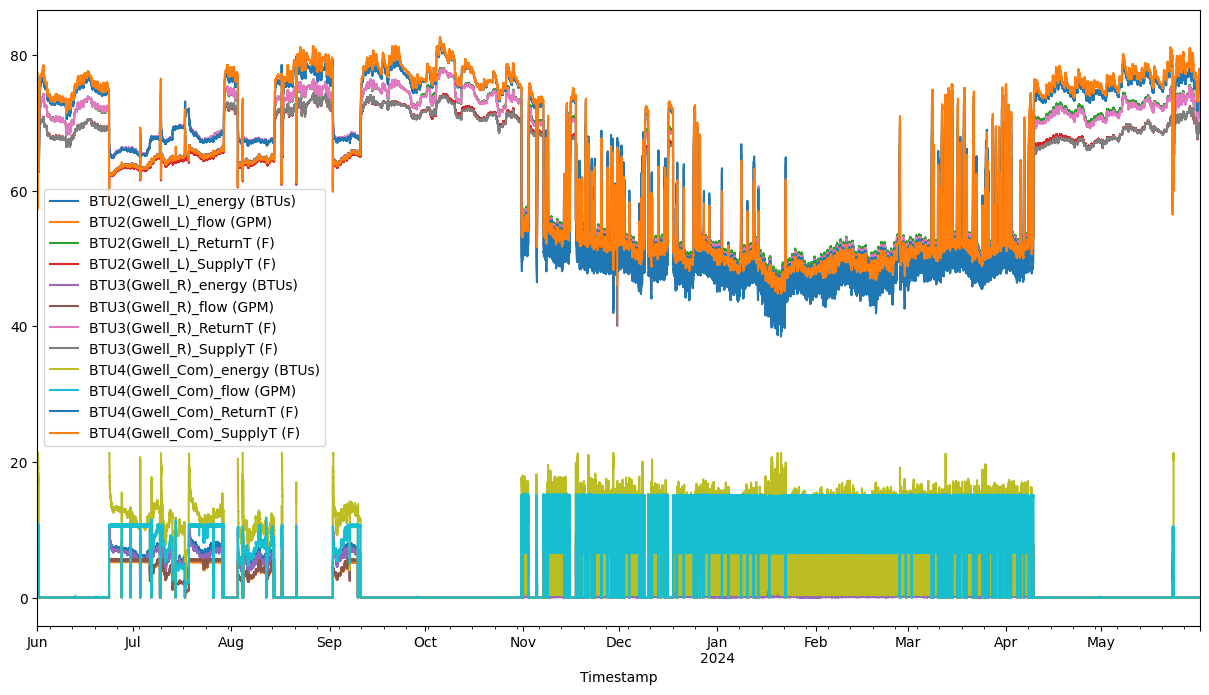

In [14]:
#Calculate Z-scores of the dataframe
z_scores = np.abs(stats.zscore(df))
# Define a threshold (e.g., 3 standard deviations)
threshold = 3
# Replace data points that are outliers with np.nan
df[(z_scores > threshold)] = np.nan

df.plot(figsize=(15, 8))

In [15]:
#Filter columns containing "(F)"
columns_with_F = [col for col in df.columns if "(F)" in col]
#Filter columns not containing "(F)"
columns_without_F = [col for col in df.columns if "(F)" not in col]

# Create two DataFrames based on the filter above
df_with_F = df[columns_with_F]
df_without_F = df[columns_without_F]

In [16]:
columns_with_F

['BTU2(Gwell_L)_ReturnT (F)',
 'BTU2(Gwell_L)_SupplyT (F)',
 'BTU3(Gwell_R)_ReturnT (F)',
 'BTU3(Gwell_R)_SupplyT (F)',
 'BTU4(Gwell_Com)_ReturnT (F)',
 'BTU4(Gwell_Com)_SupplyT (F)']

In [17]:
# Update 'Lst_name' to contain the names of columns that include "(F)".
Lst_name = columns_with_F

In [18]:
# Checking the type of the element in the q_values of 'Lst_name' (This should show a numpy float!)
type(q_values[Lst_name][0])

C:\Users\Sang\AppData\Local\Temp\ipykernel_34204\2880792931.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(q_values[Lst_name][0])


numpy.float64

Absolute Difference Outlier Removal

In [19]:
#Iterate over the list of column with F
for i in range(0,len(Lst_name)):
    df = df_with_F[Lst_name[i]]
###     print (abs(df.diff())> q_values[Lst_name][i])
###     df_with_F[Lst_name[i]] = df.drop(df[abs(df.diff())> q_values[Lst_name][i]].index)
    #If the absolute difference between consecutive values is greater than 5, drop them.
    df_with_F[Lst_name[i]] = df.drop(df[abs(df.diff())> 5].index)

C:\Users\Sang\AppData\Local\Temp\ipykernel_34204\3662521107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_F[Lst_name[i]] = df.drop(df[abs(df.diff())> 5].index)


<Axes: xlabel='Timestamp'>

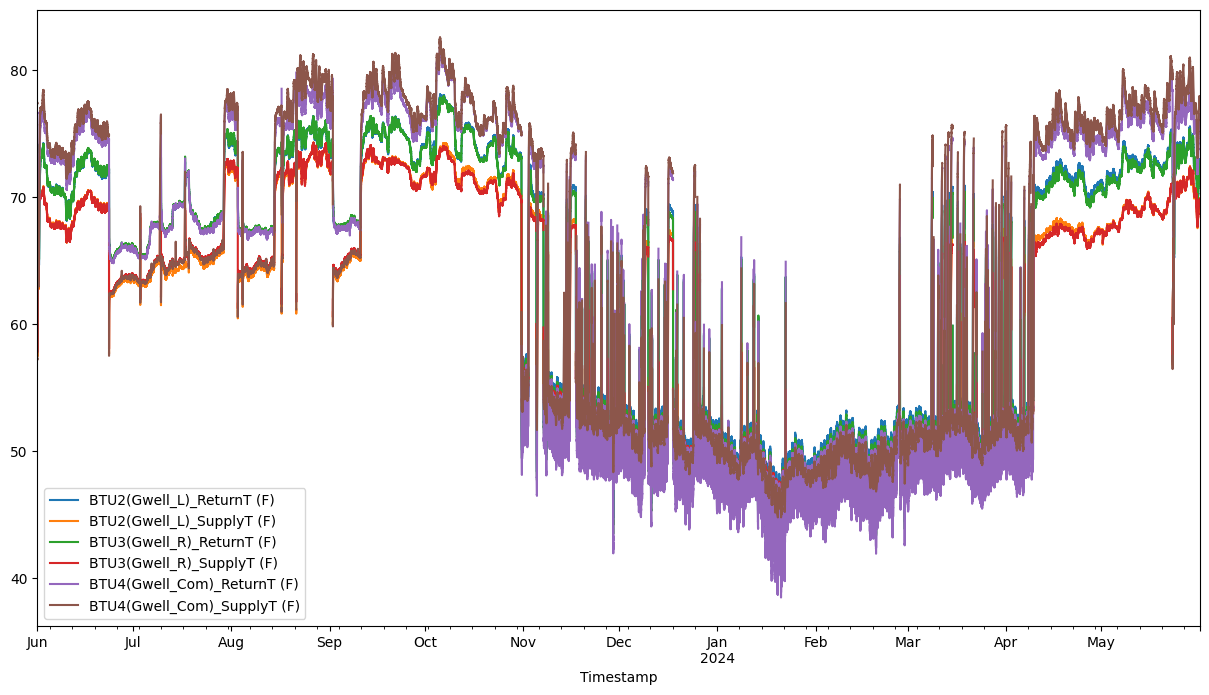

In [20]:
df_with_F.plot(figsize=(15, 8))

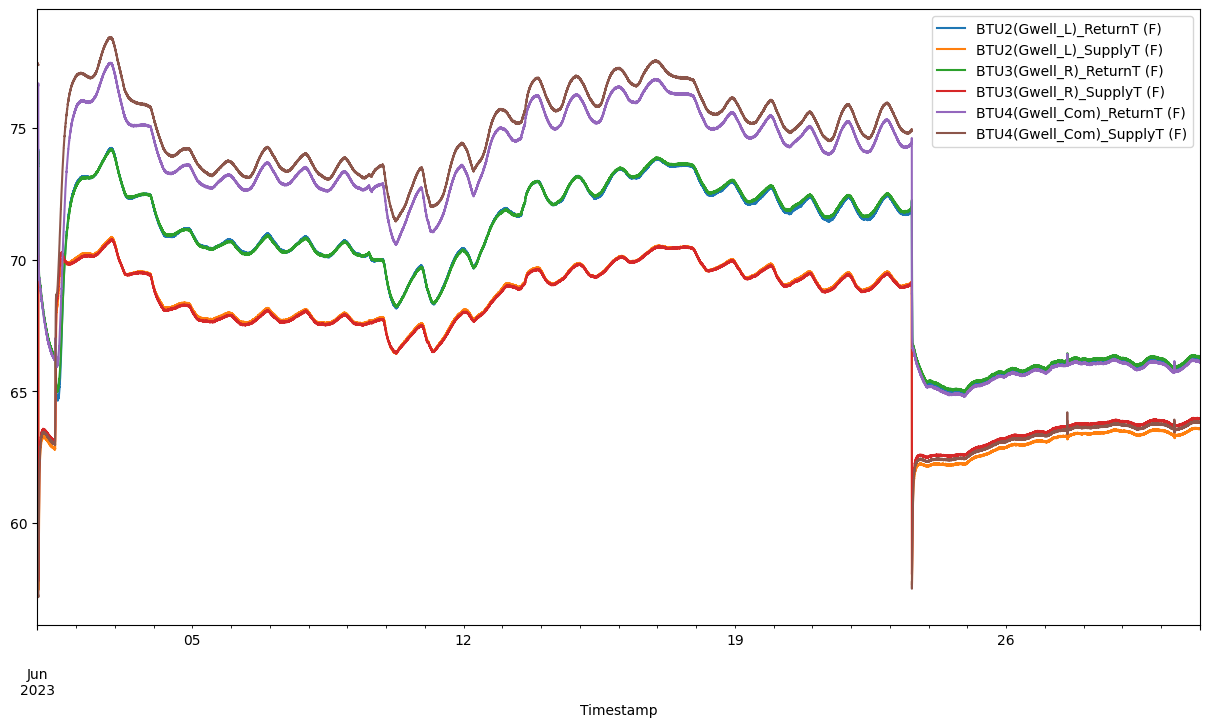

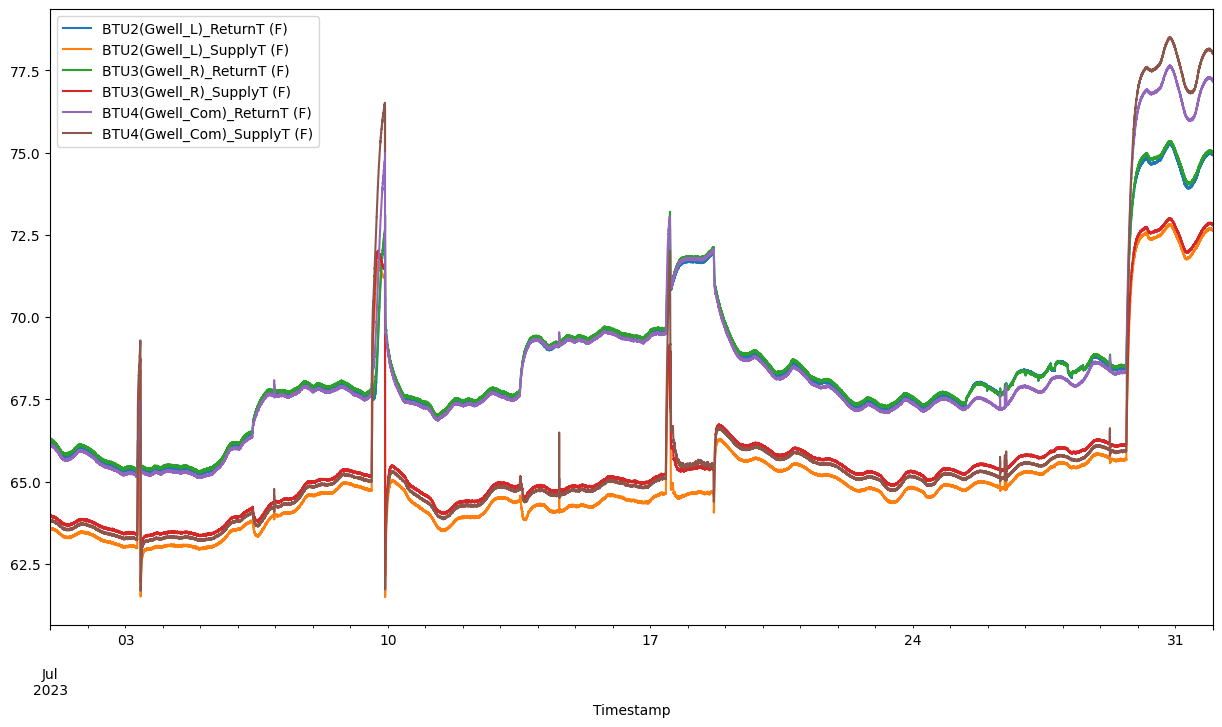

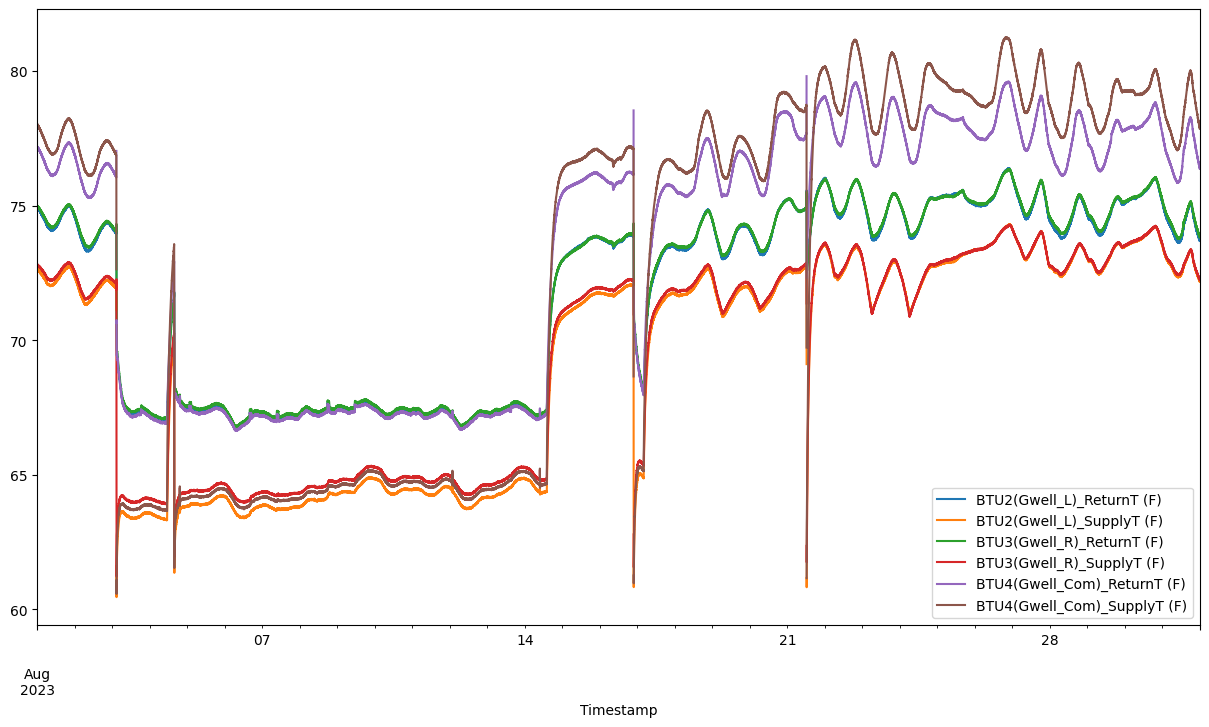

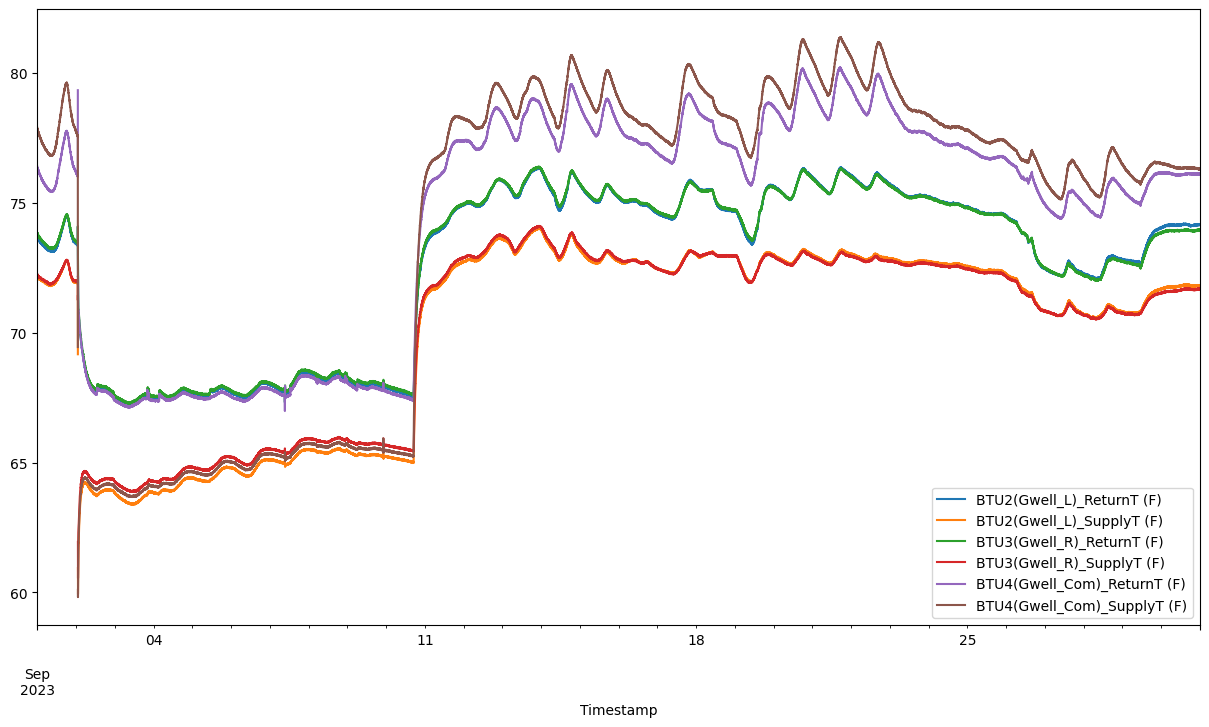

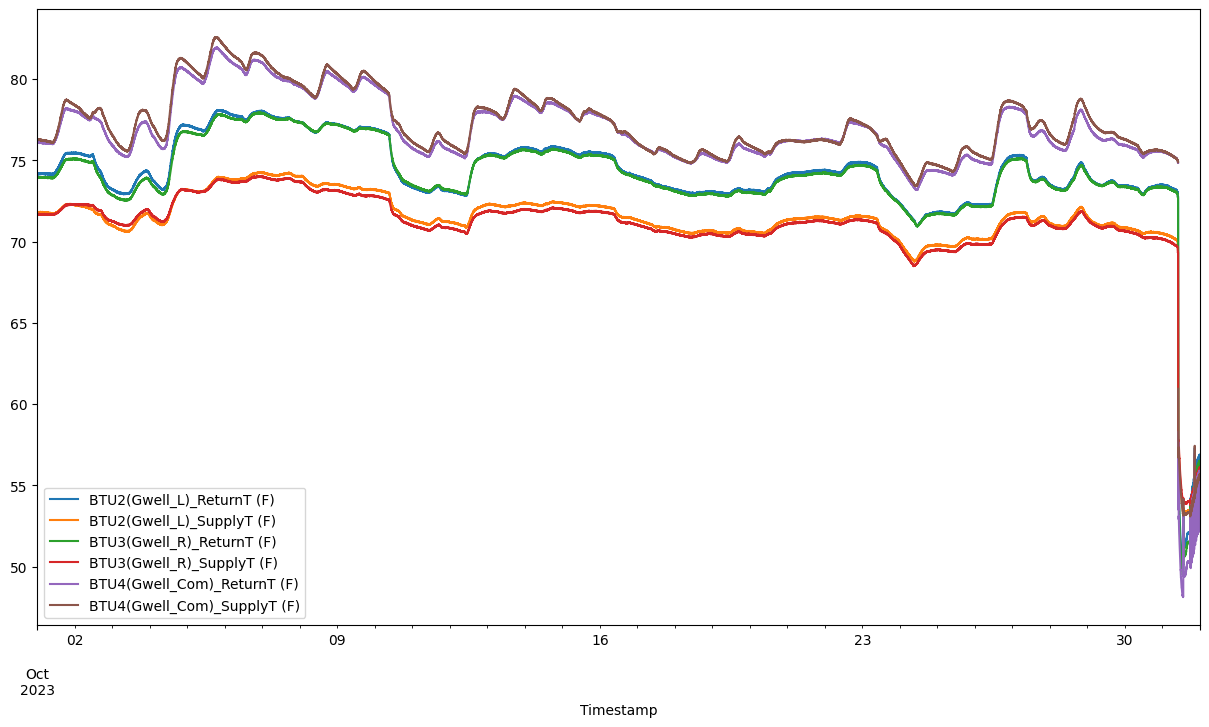

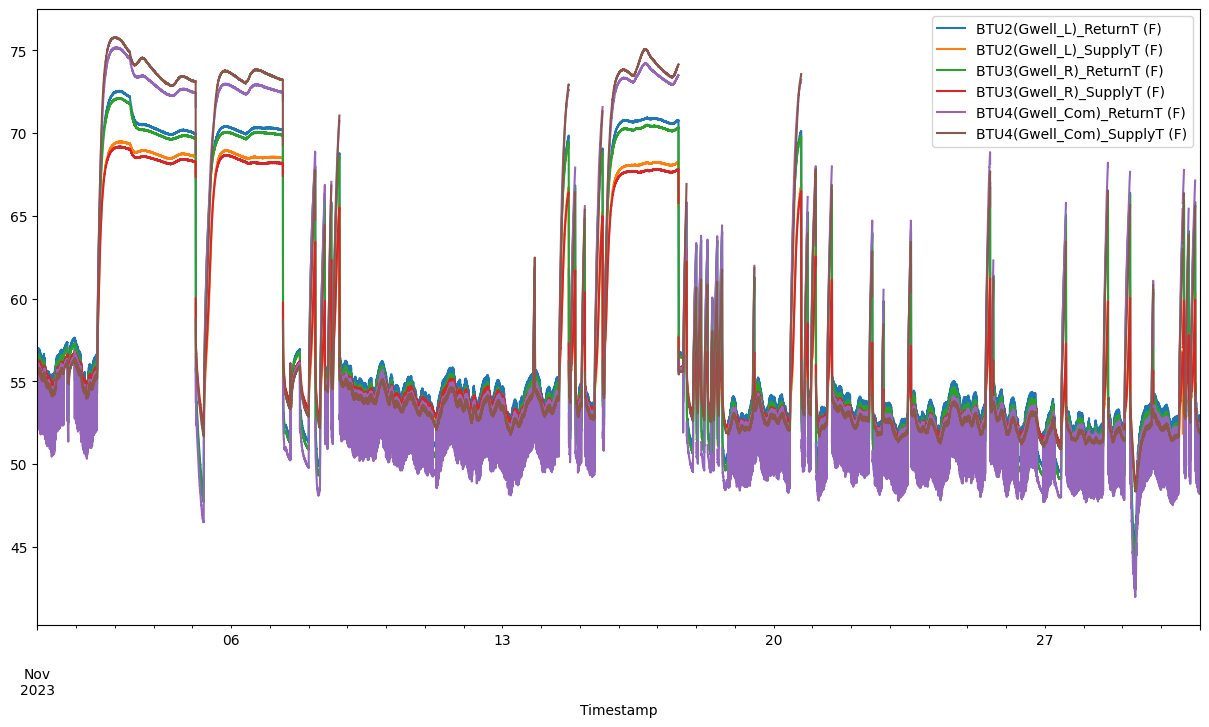

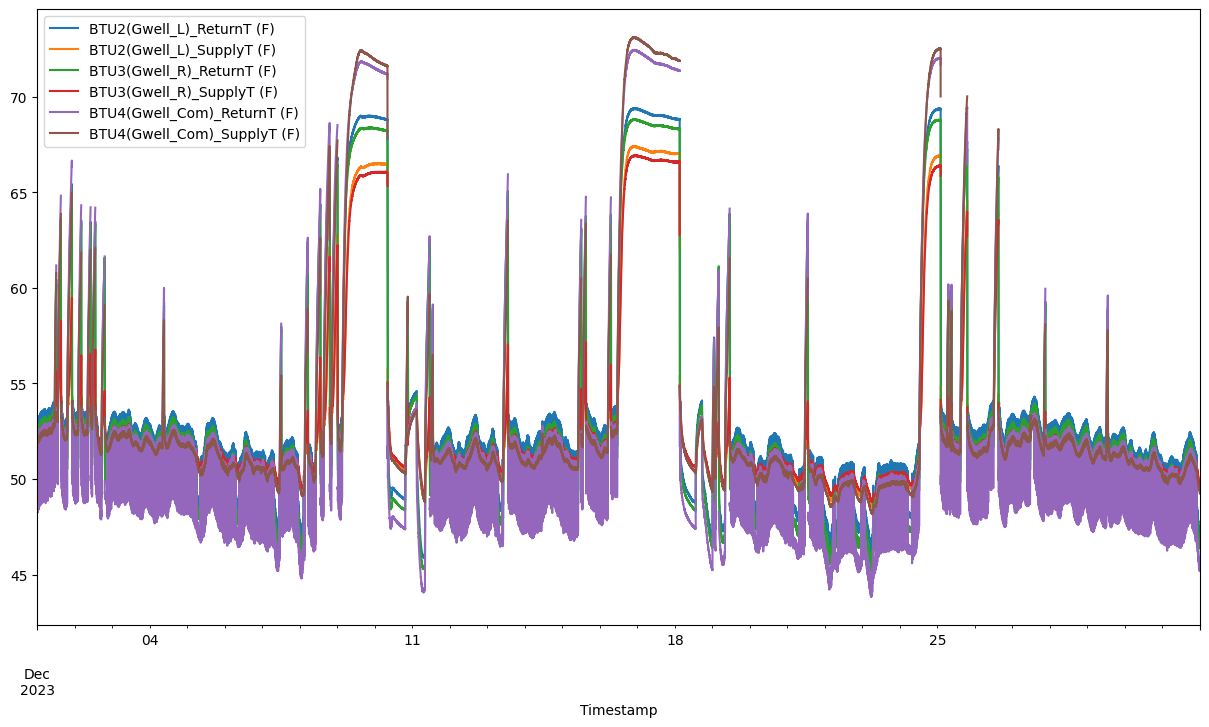

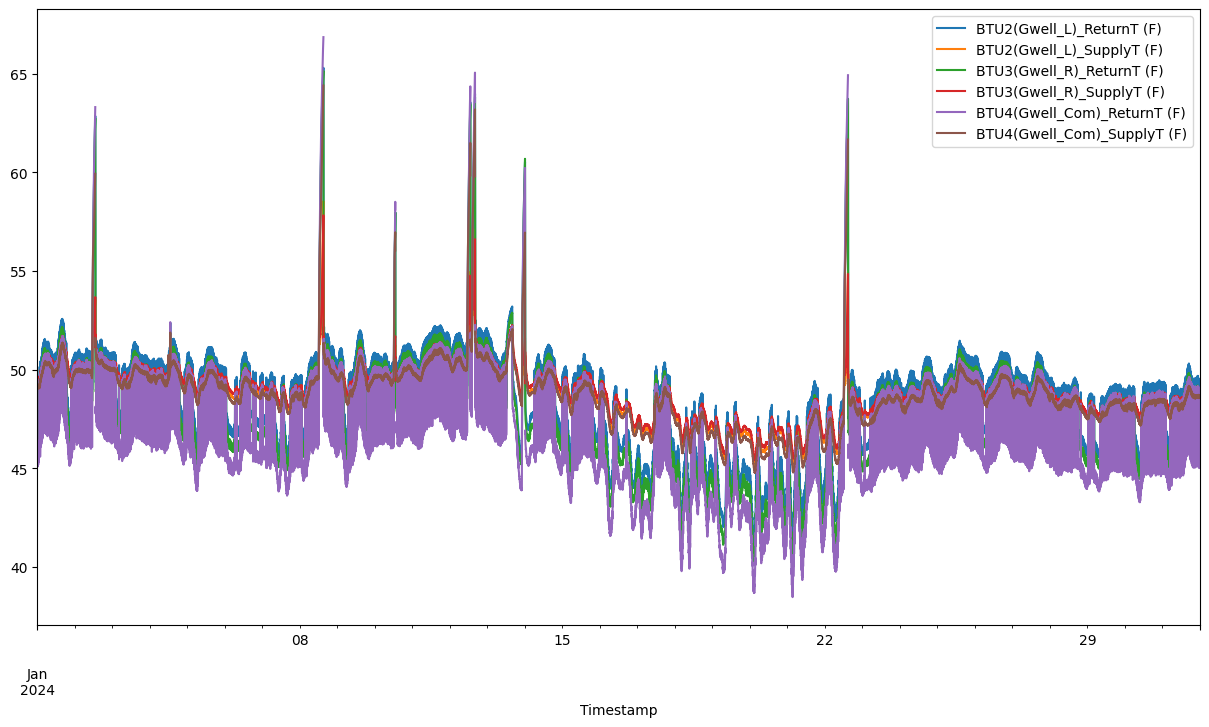

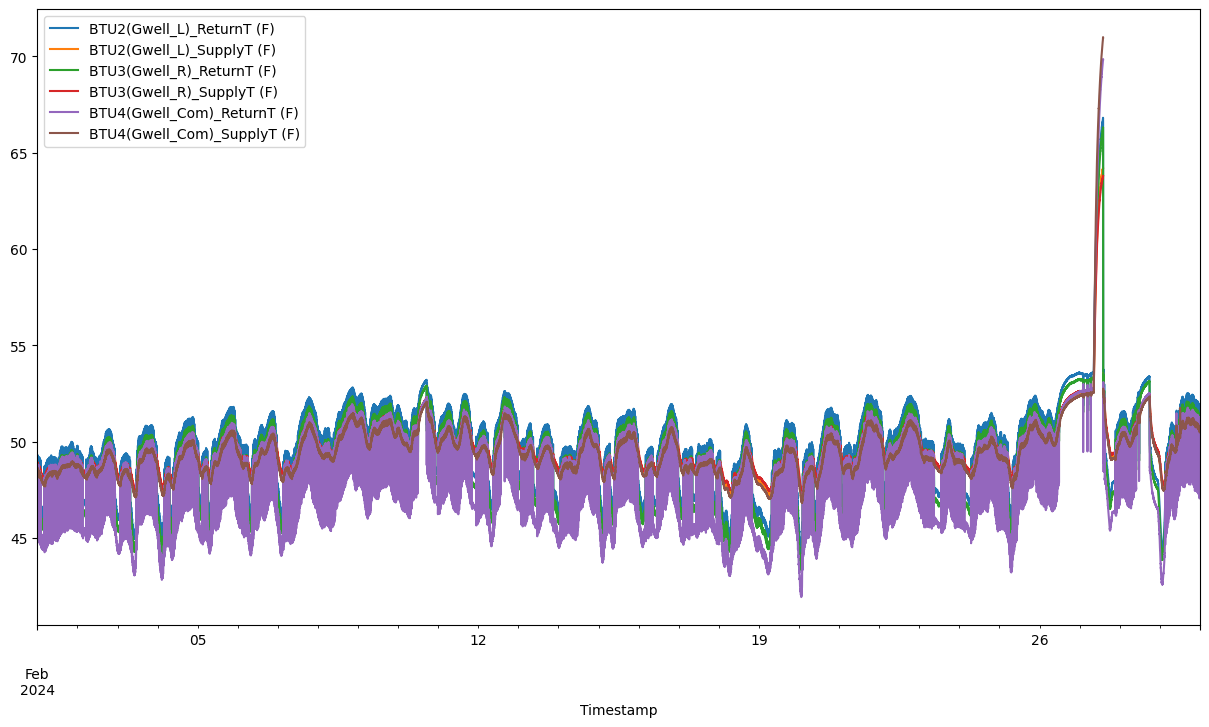

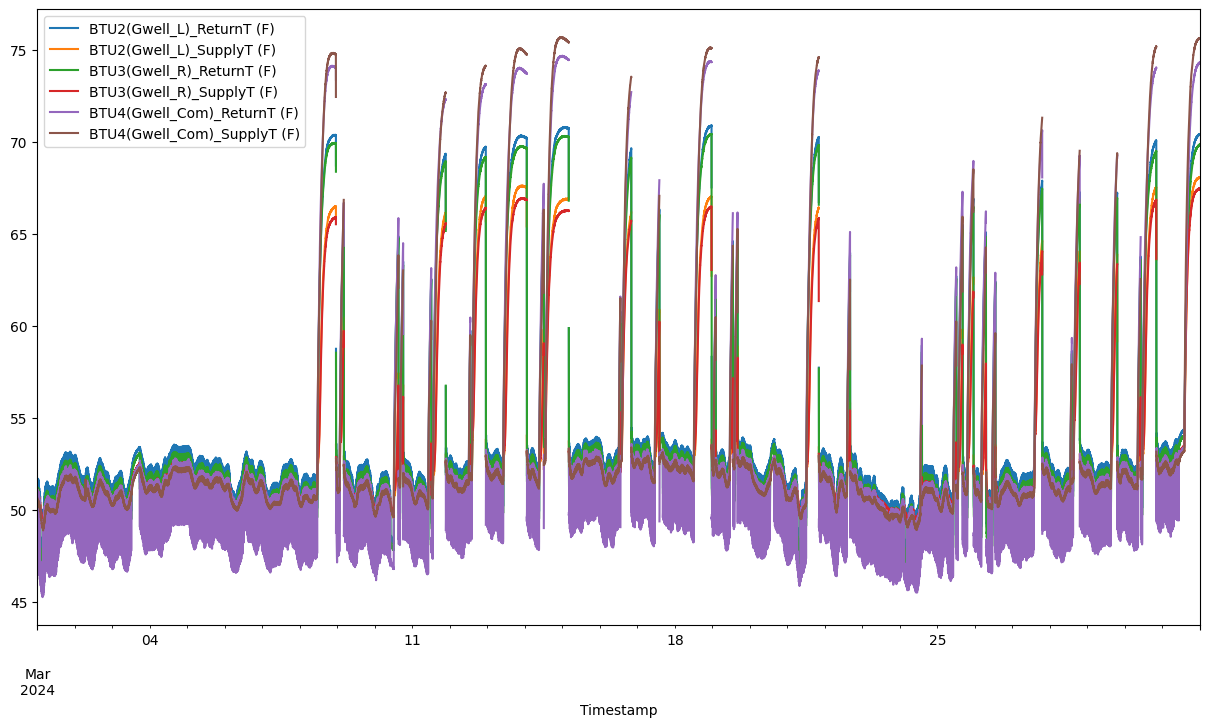

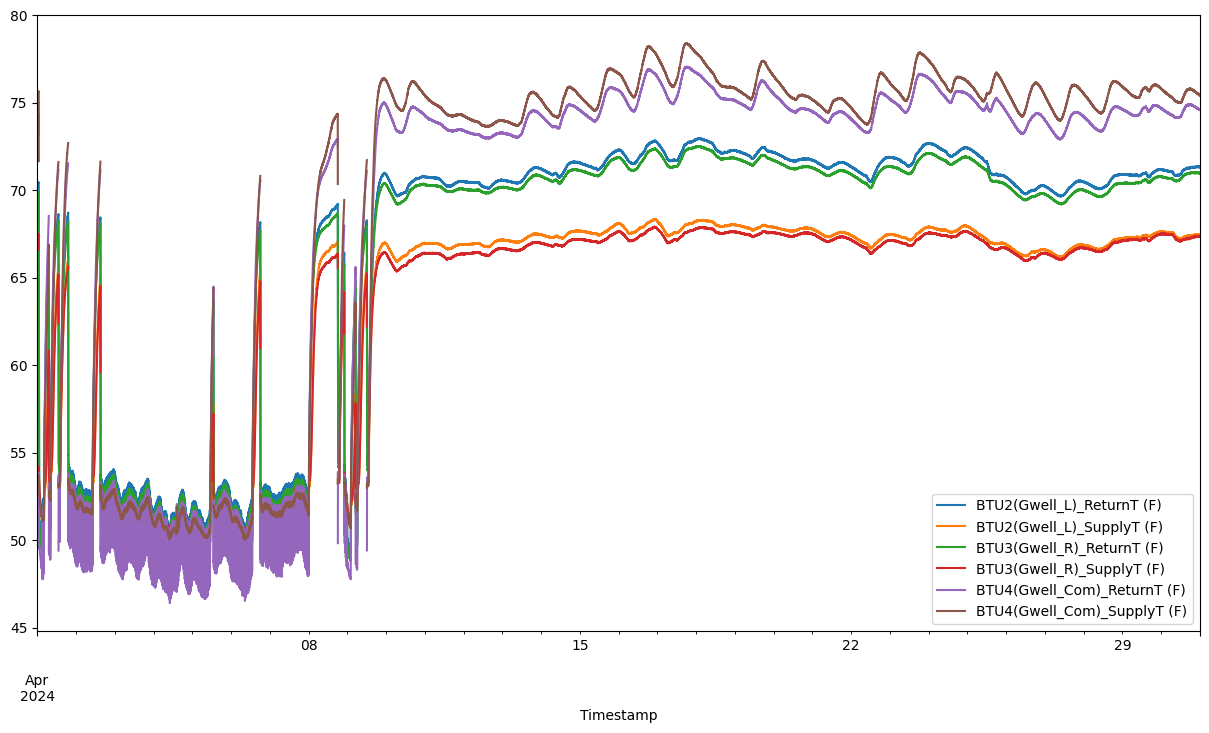

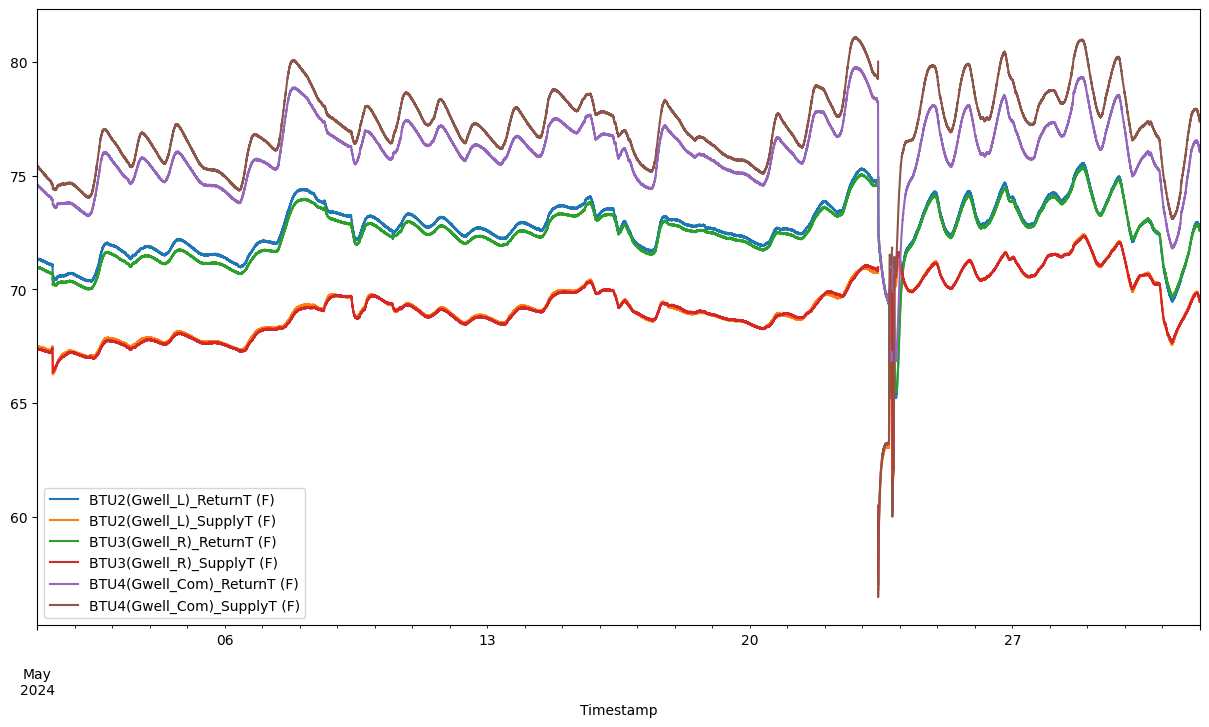

In [21]:
#Then, group by year and week number and apply Mahalanobis distance function
for (year, month), group in df_with_F.groupby([df_with_F.index.year, df_with_F.index.month]):

    group.plot(figsize=(15, 8))
    

Mahalanobis Distance Outlier Removal

In [22]:
def mahalanobis_distance(x, data):
    """Calculate the Mahalanobis distance for each observation in x from the distribution of data"""
    x_minus_mu = x - np.mean(data)
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

def remove_outliers(df, columns):
    # Assuming df has a datetime index, group by year and month
    groups = df.groupby([df.index.year, df.index.month])
    
    # Process each group
    for (year, month), group in groups:
        feature_set = group[columns]
        
        # Skip groups with less data points than columns to avoid singular matrix error
        if feature_set.shape[0] <= feature_set.shape[1]:
            continue
        
        # Compute the Mahalanobis distance for each observation
        group['mahalanobis'] = mahalanobis_distance(x=feature_set, data=feature_set)
        # Calculate the p-value for each Mahalanobis distance
        group['p_value'] = 1 - chi2.cdf(group['mahalanobis'], df=feature_set.shape[1])
        
        # Choose a significance level
        significance_level = 0.05
        # Identify outliers
        outliers = group['p_value'] < significance_level
        # Set outliers to NaN
        df.loc[group[outliers].index, columns] = np.nan
    
    # Drop columns for Mahalanobis distance and p-value if they exist
    df.drop(columns=['mahalanobis', 'p_value'], errors='ignore', inplace=True)
    
    return df

# Define subsets for each zone (based on return or supply)
Zone_Temp_base = ['BTU2(Gwell_L)_ReturnT (F)', 'BTU3(Gwell_R)_ReturnT (F)','BTU4(Gwell_Com)_ReturnT (F)']
Zone_Temp_fir = ['BTU2(Gwell_L)_SupplyT (F)', 'BTU3(Gwell_R)_SupplyT (F)','BTU4(Gwell_Com)_SupplyT (F)']


In [23]:
df_with_F.columns.values

array(['BTU2(Gwell_L)_ReturnT (F)', 'BTU2(Gwell_L)_SupplyT (F)',
       'BTU3(Gwell_R)_ReturnT (F)', 'BTU3(Gwell_R)_SupplyT (F)',
       'BTU4(Gwell_Com)_ReturnT (F)', 'BTU4(Gwell_Com)_SupplyT (F)'],
      dtype=object)

<Axes: xlabel='Timestamp'>

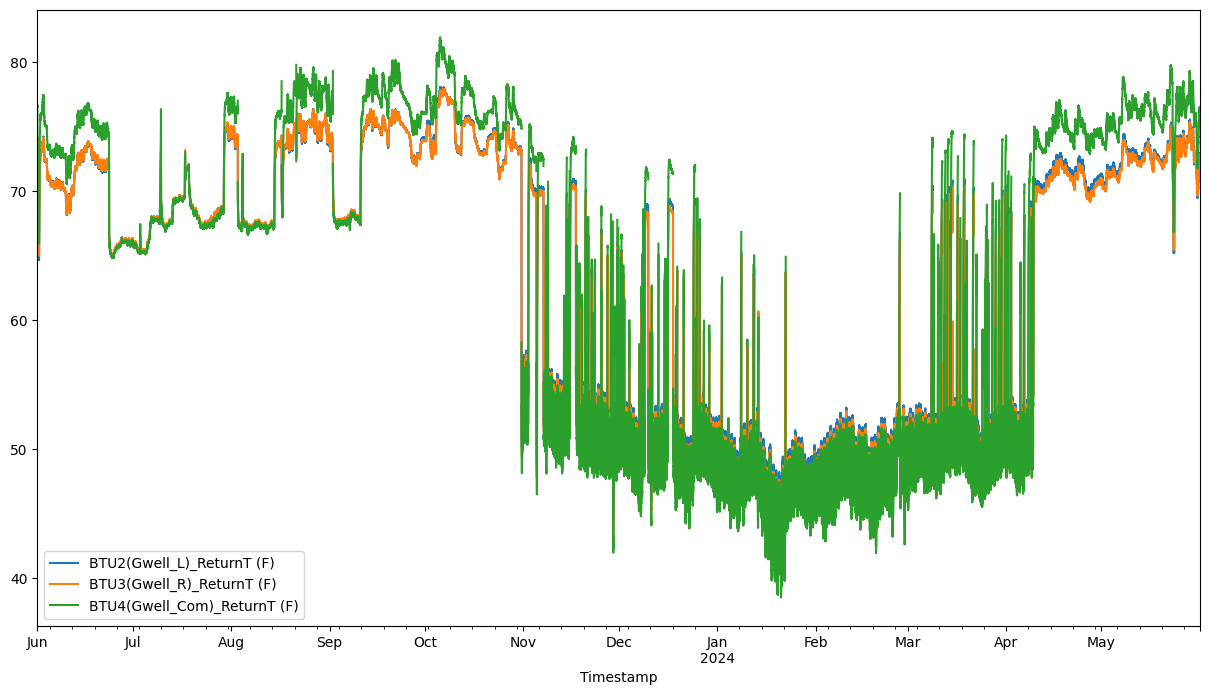

In [24]:
df_with_F[Zone_Temp_base].plot(figsize=(15, 8))

<Axes: xlabel='Timestamp'>

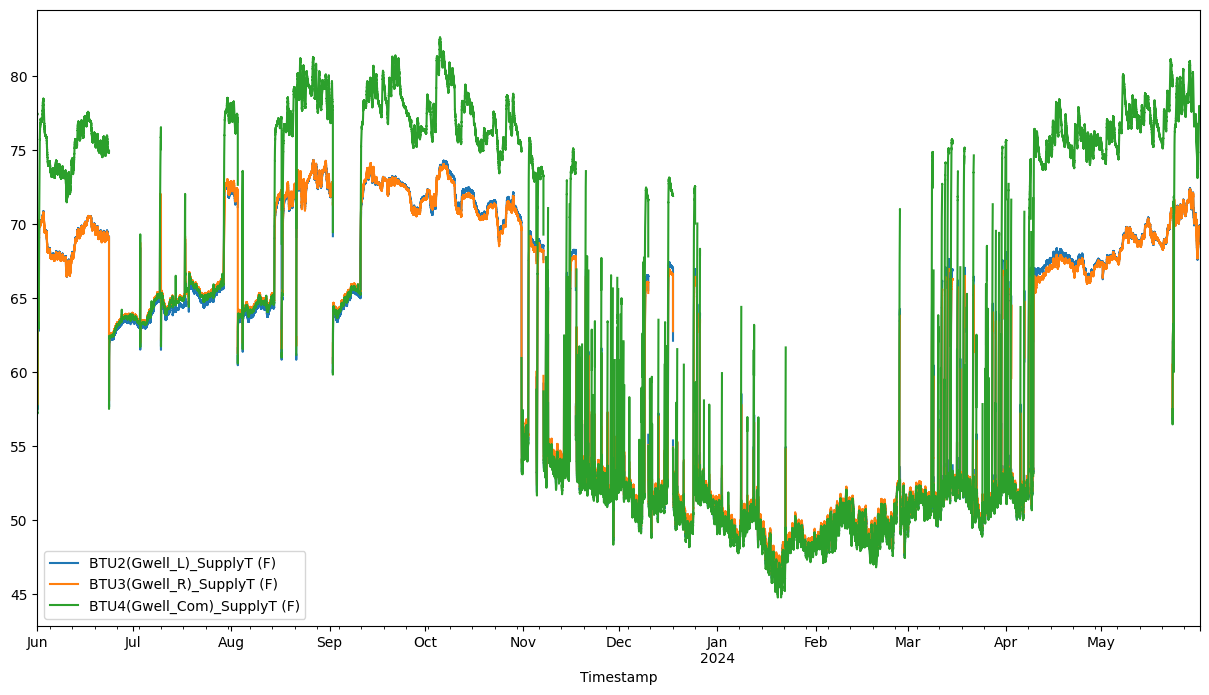

In [25]:
df_with_F[Zone_Temp_fir].plot(figsize=(15, 8))

<Axes: xlabel='Timestamp'>

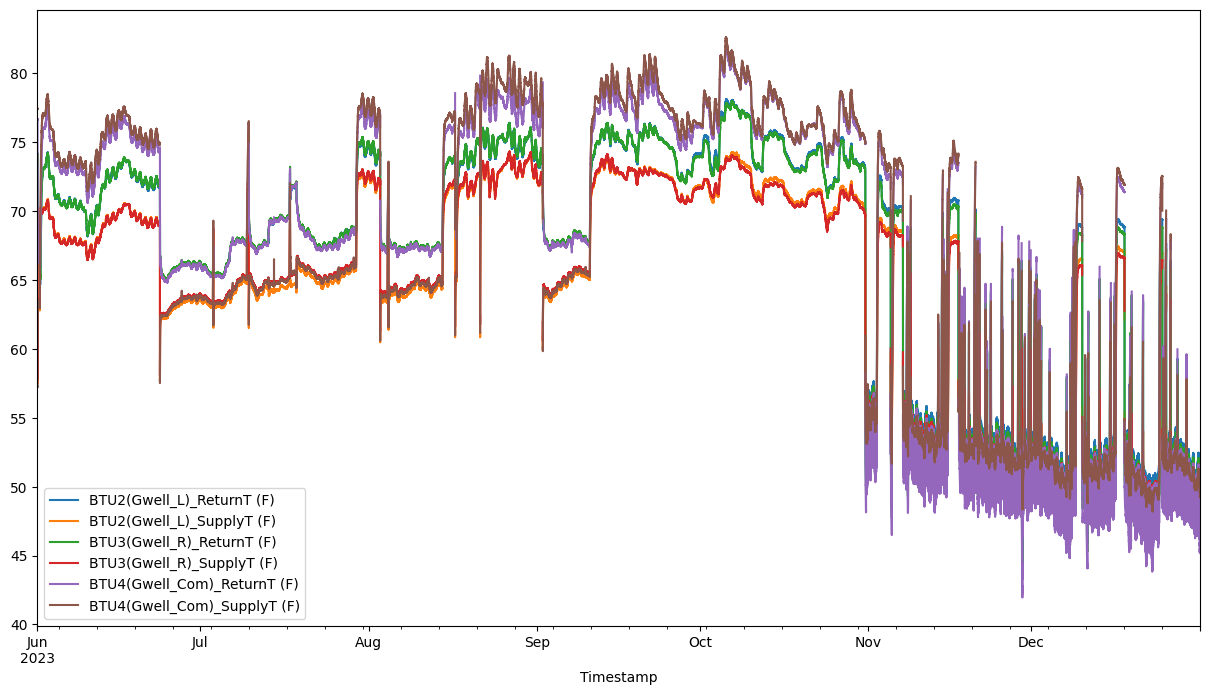

In [26]:
df_with_F1 = df_with_F[: "2023-12-31"]

df_with_F1.plot(figsize=(15, 8))

In [22]:
#DO NOT APPLY MAHALANOBIS DISTANCE HERE
#Removes correct data: BTU3(Gwell_R)_ReturnT (F)

#Use Mahalanobis distance to remove the outliers
# df_with_F1 = remove_outliers(df_with_F1, Zone_Temp_base)
# df_with_F1 = remove_outliers(df_with_F1, Zone_Temp_fir)

# df_with_F1.plot(figsize=(15, 8))

<Axes: xlabel='Timestamp'>

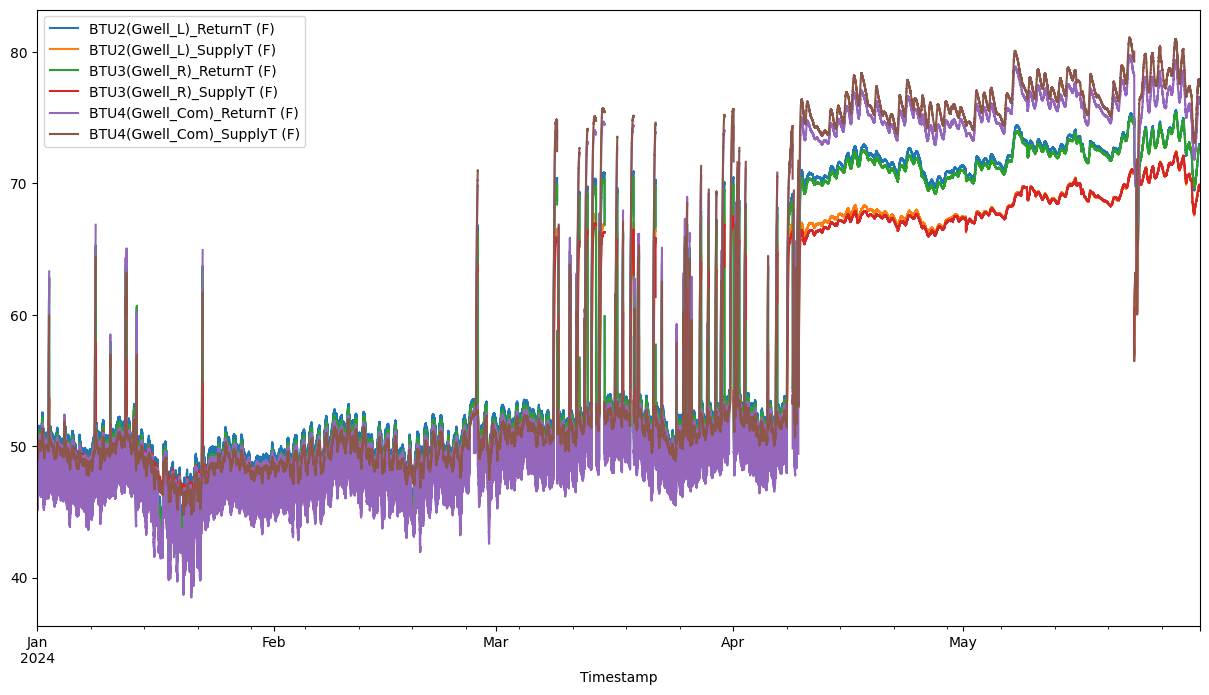

In [27]:
df_with_F2 = df_with_F["2024-01-01":]

df_with_F2.plot(figsize=(15, 8))

C:\Users\Sang\AppData\Local\Temp\ipykernel_17916\2533731224.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['mahalanobis', 'p_value'], errors='ignore', inplace=True)
C:\Users\Sang\AppData\Local\Temp\ipykernel_17916\2533731224.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['mahalanobis', 'p_value'], errors='ignore', inplace=True)


<Axes: xlabel='Timestamp'>

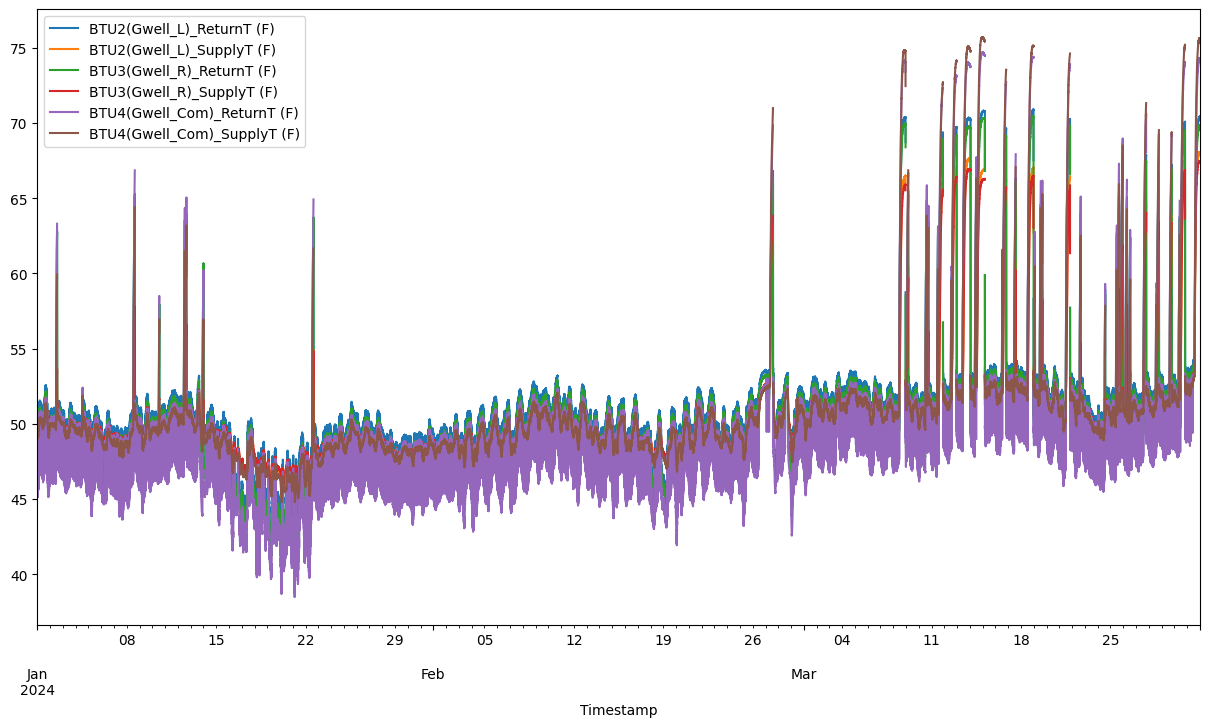

In [24]:
df_with_F2 = remove_outliers(df_with_F2, Zone_Temp_base)
df_with_F2 = remove_outliers(df_with_F2, Zone_Temp_fir)

df_with_F2.plot(figsize=(15, 8))

In [28]:
# Combine all dataframes
combined_df = pd.concat([df_with_F1, df_with_F2])

In [29]:
# Convert Fahrenheit to Celsius
combined_df = (combined_df - 32) * 5/9
# Renaming columns: Replace 'F' with 'C'
combined_df.columns = [col.replace('F', 'C') for col in combined_df.columns]


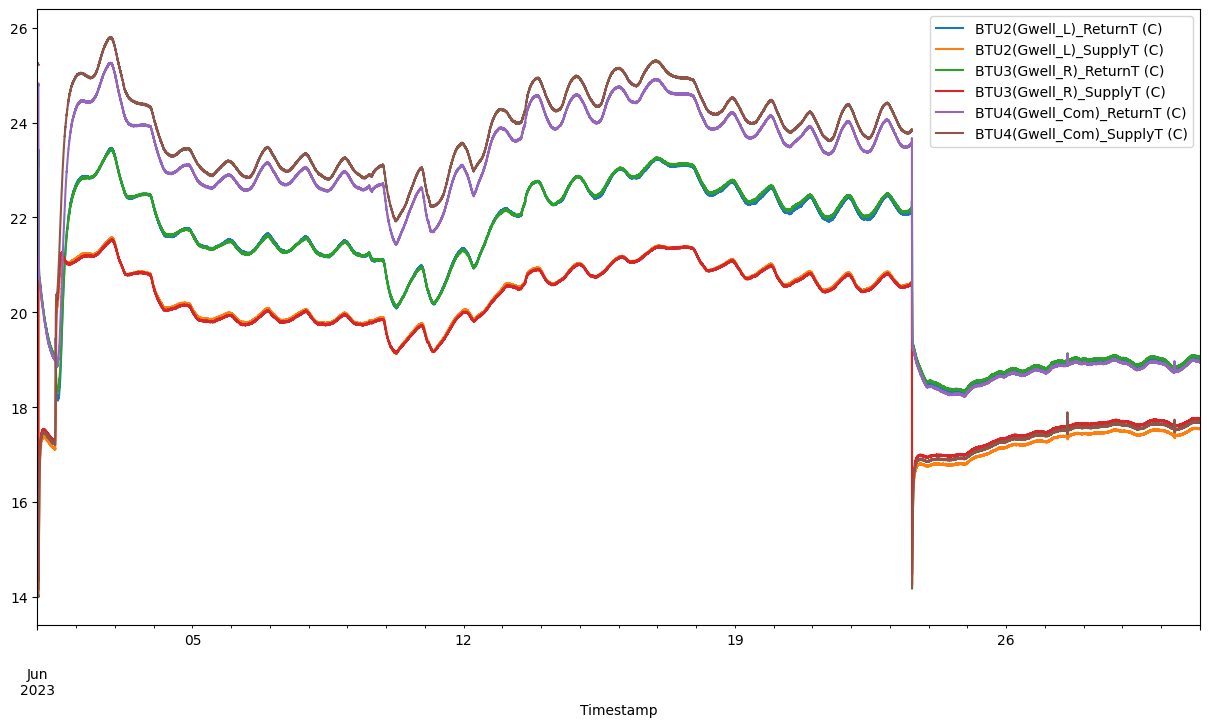

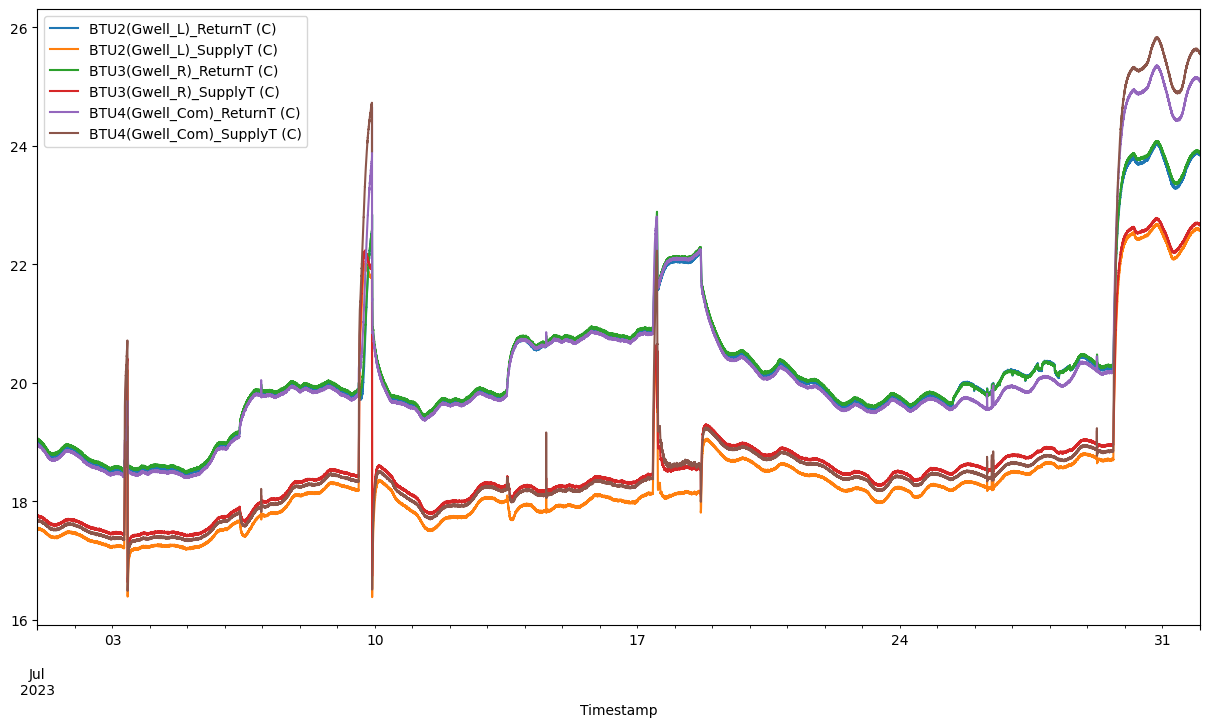

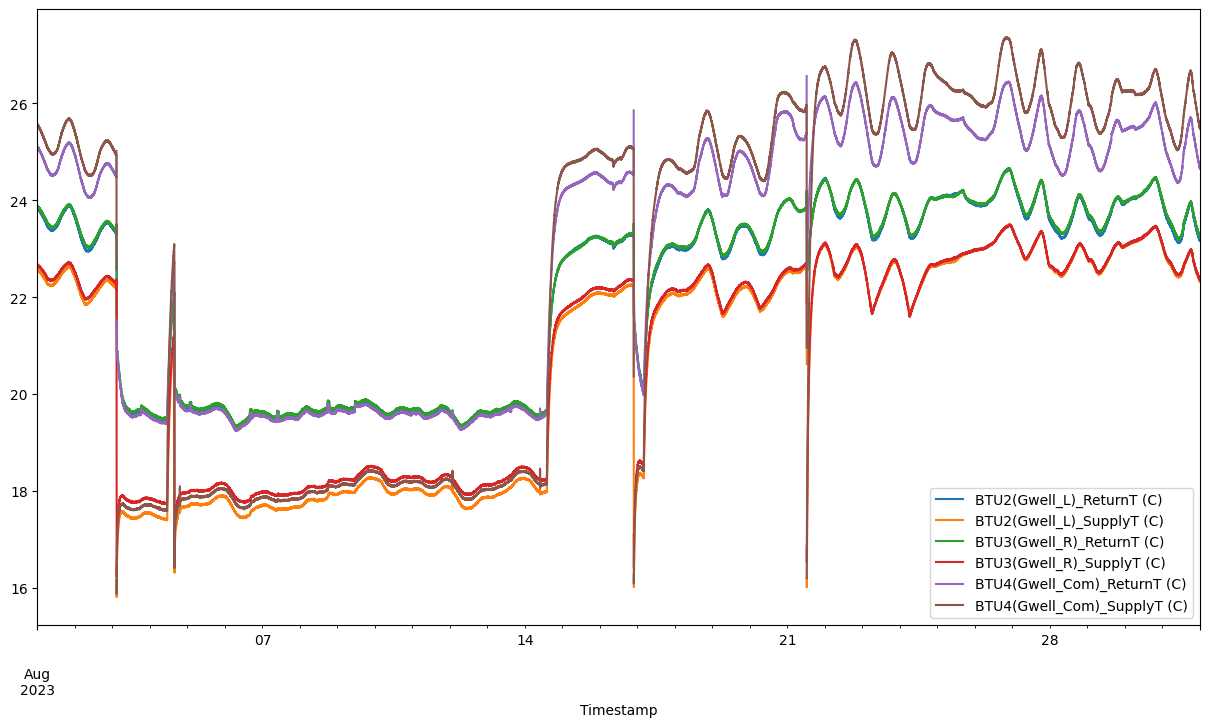

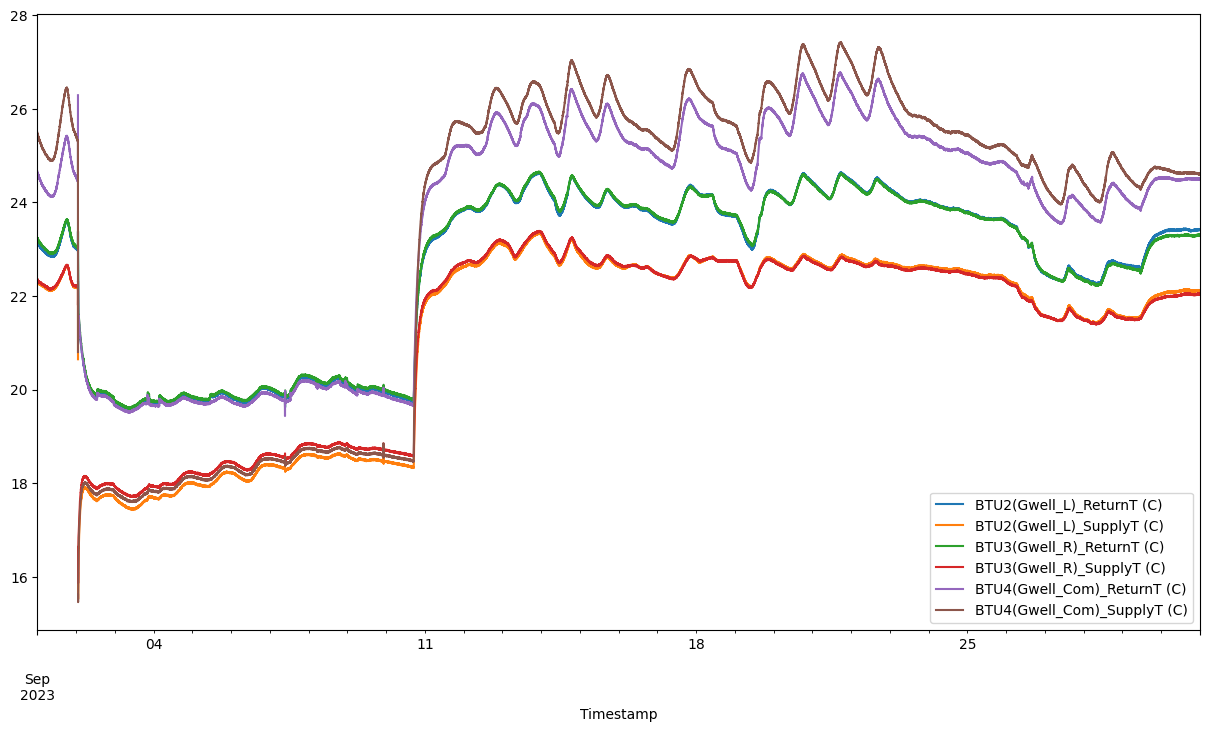

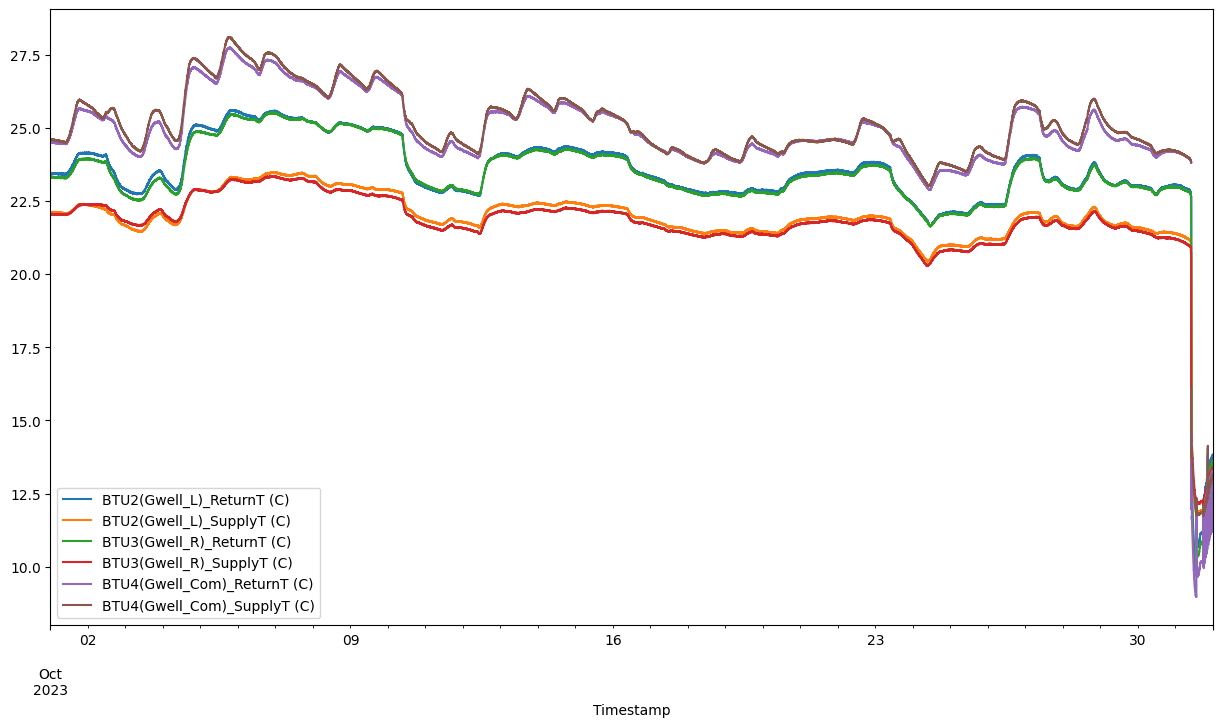

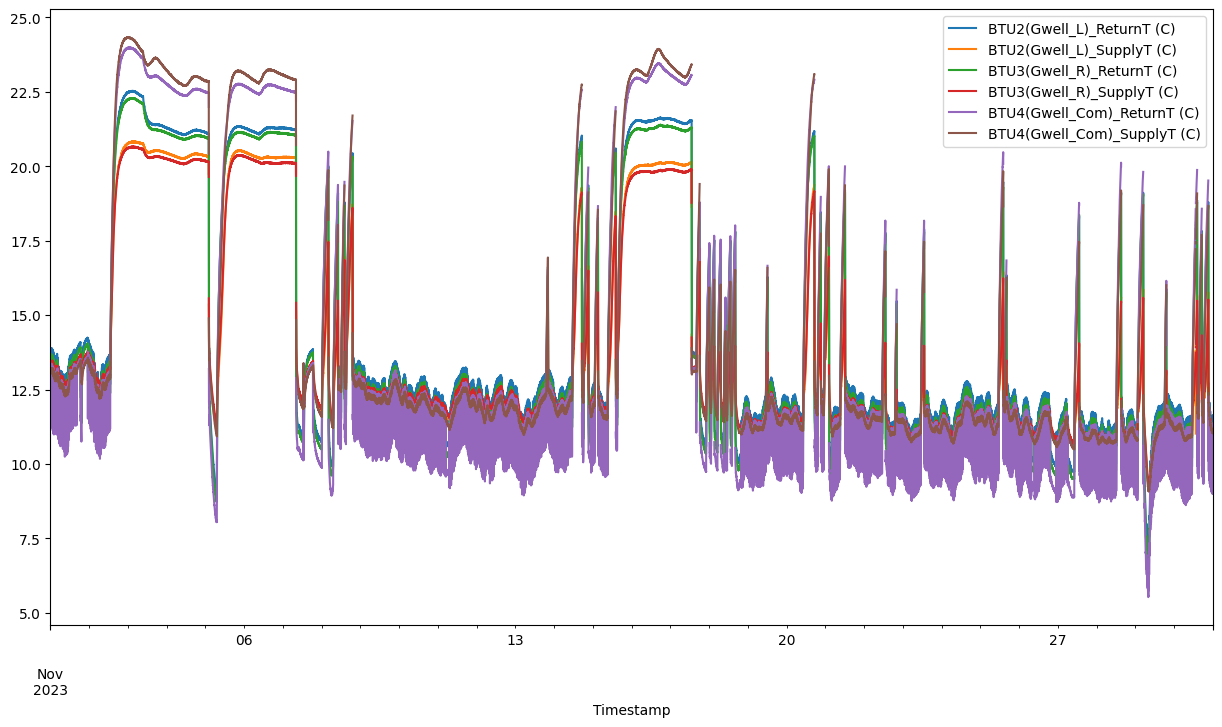

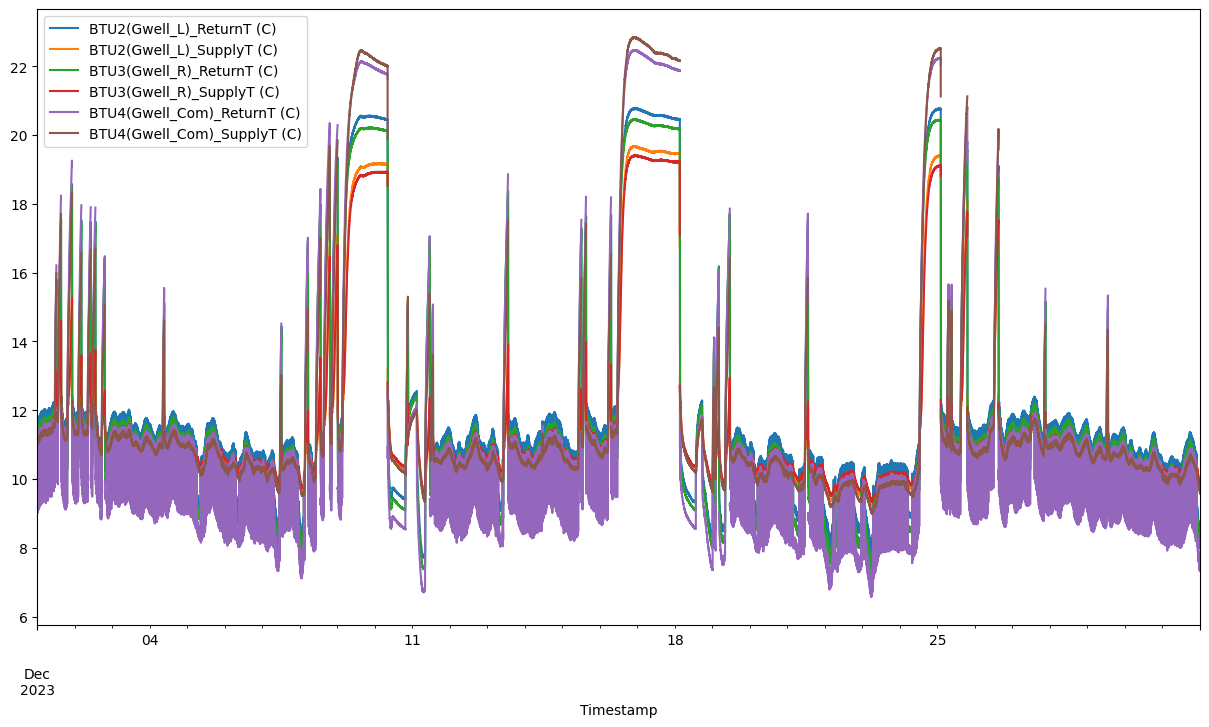

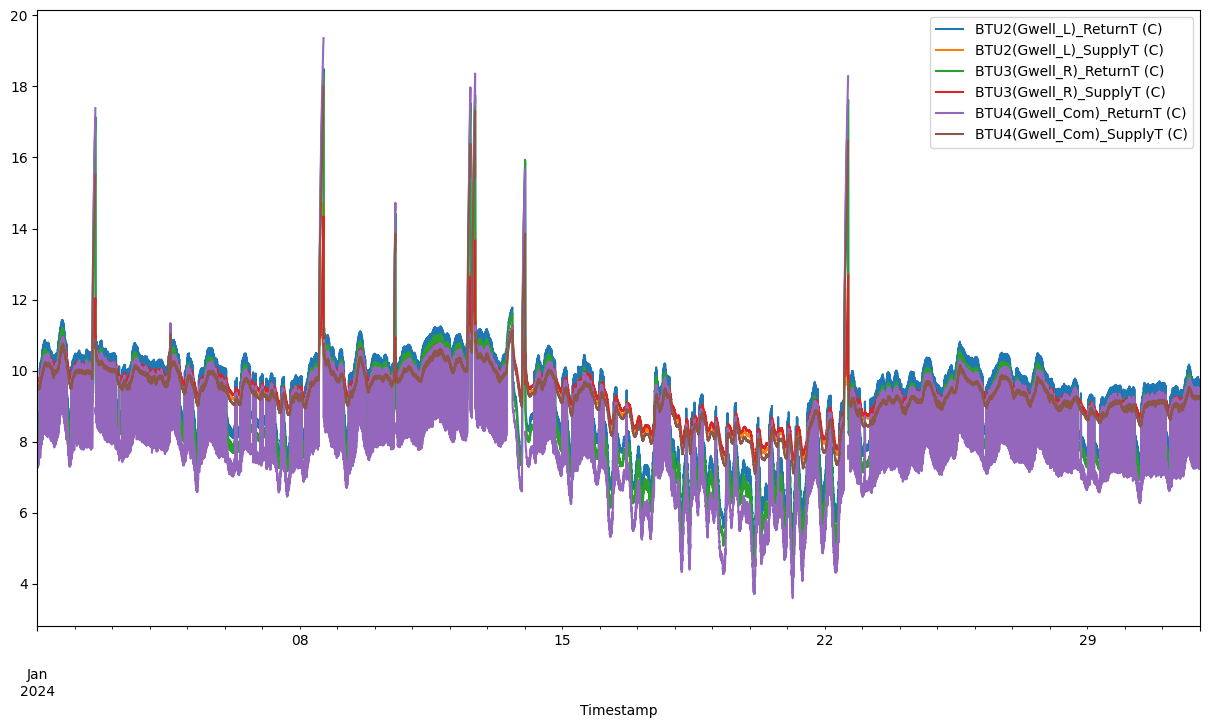

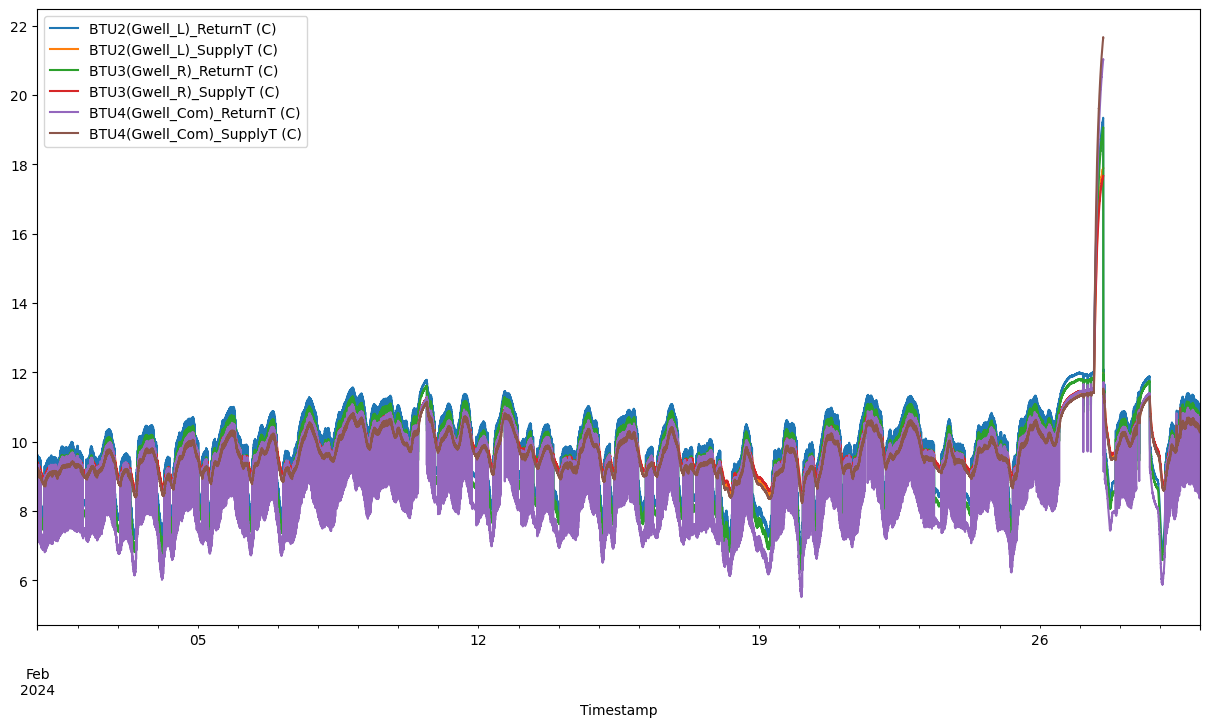

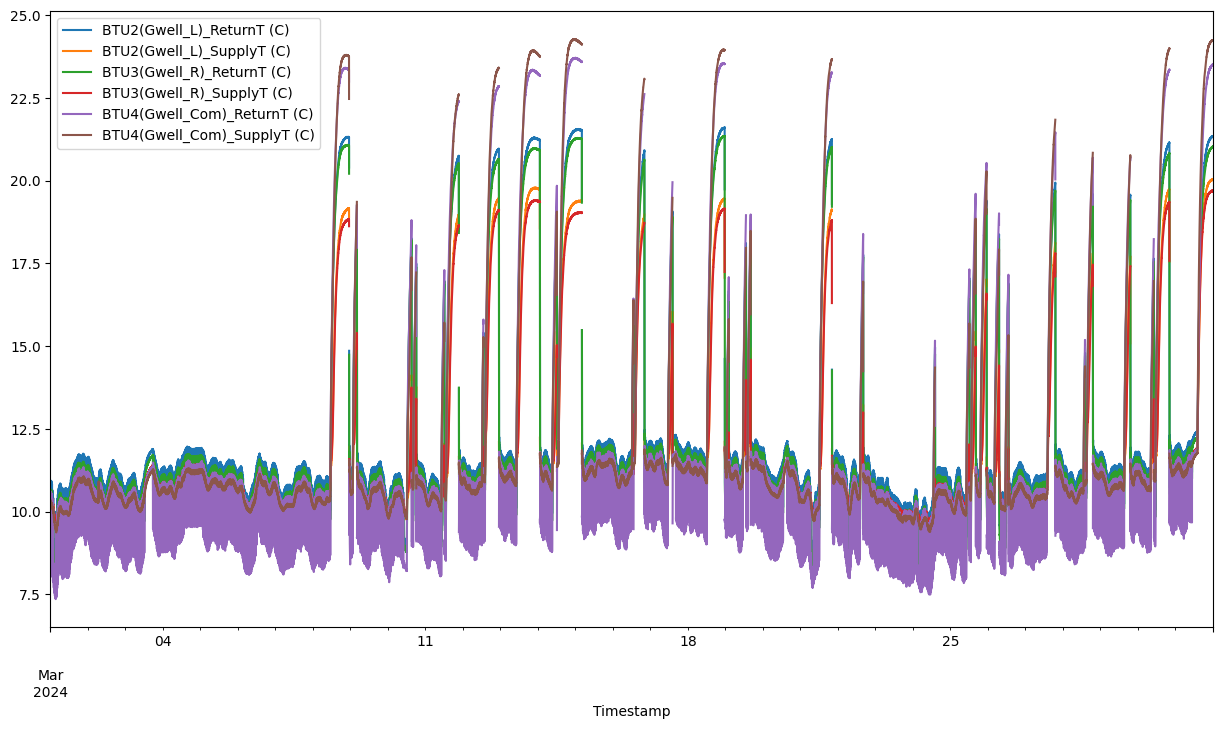

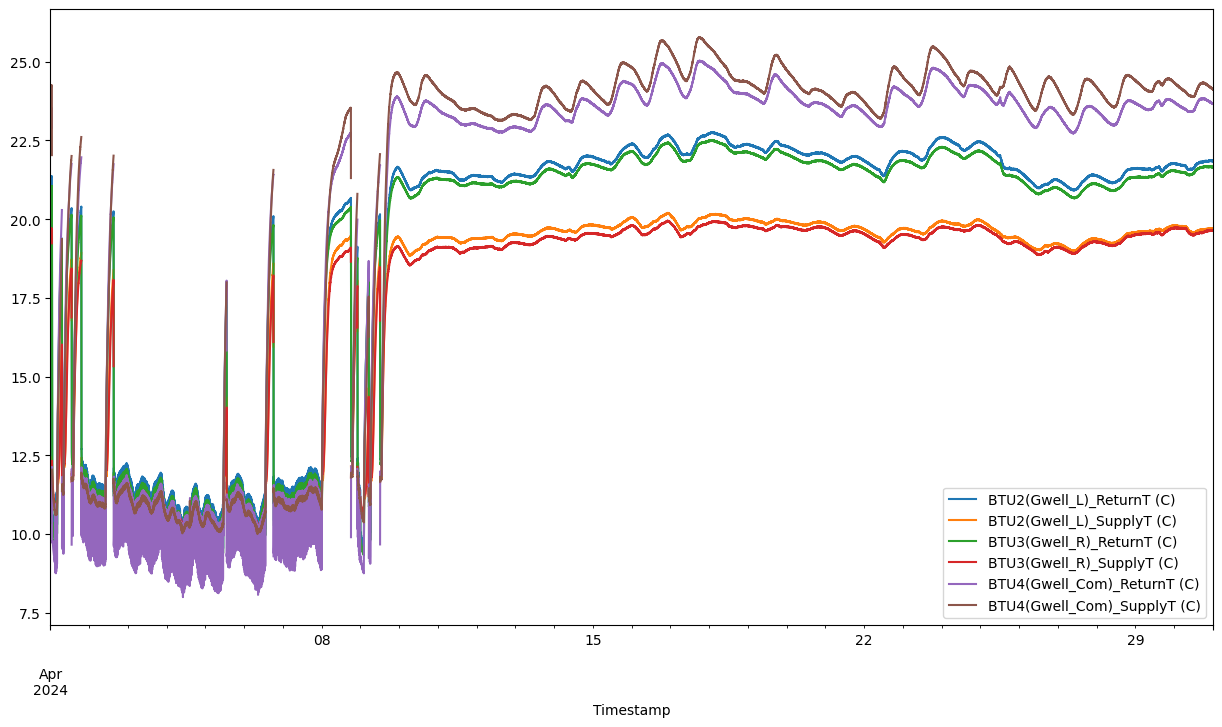

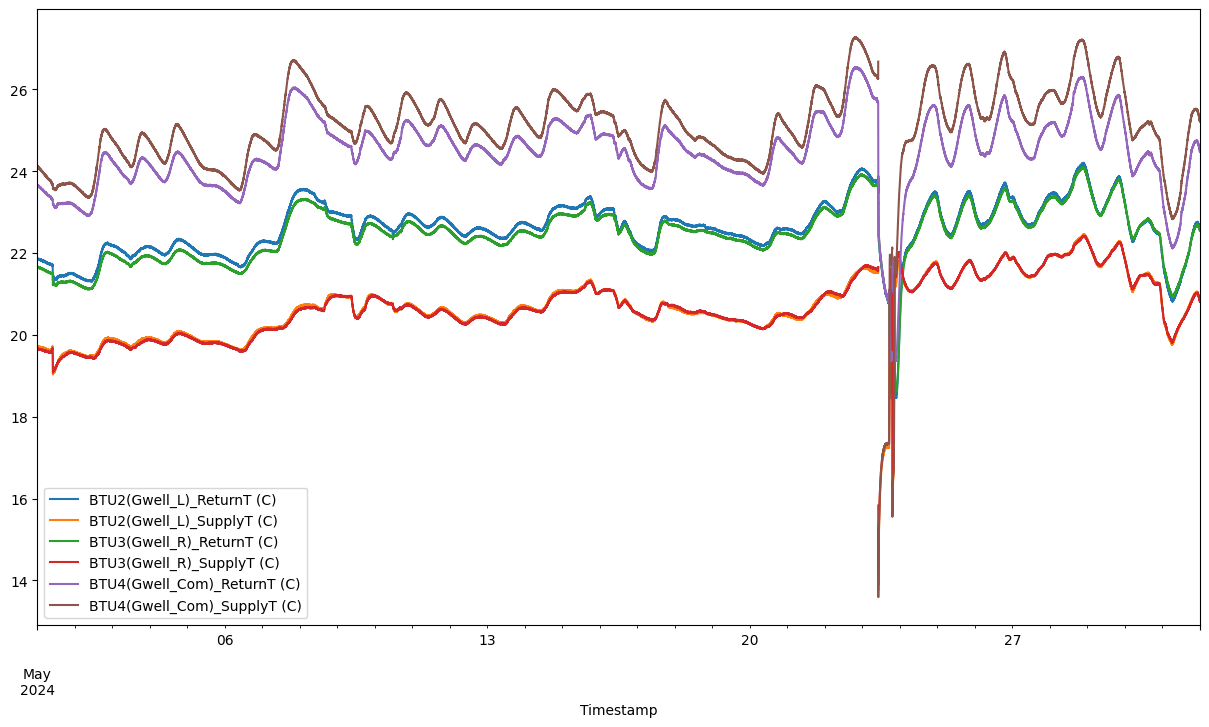

In [30]:
#Group by months, then plot each month for detailed assessment
for (year, month), group in combined_df.groupby([combined_df.index.year, combined_df.index.month]):

    group.plot(figsize=(15, 8))

In [31]:
df_with_F

BTU2(Gwell_L)_ReturnT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  73.654083   
2023-06-01 00:01:00-04:00                  73.668716   
2023-06-01 00:02:00-04:00                  73.682922   
2023-06-01 00:03:00-04:00                  73.671501   
2023-06-01 00:04:00-04:00                  73.678253   
...                                              ...   
2024-05-31 23:55:00-04:00                  72.690323   
2024-05-31 23:56:00-04:00                  72.680077   
2024-05-31 23:57:00-04:00                  72.661713   
2024-05-31 23:58:00-04:00                  72.676994   
2024-05-31 23:59:00-04:00                  72.661758   

                           BTU2(Gwell_L)_SupplyT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  70.168900   
2023-06-01 00:01:00-04:00                  70.170502   
2023-06-01 00:02:00-04:00                  70.187599   
2023-06-01 00:03:00-04:00                  70.166016   
2023-06-01 00:04:00-04:00                  70.169151   
...                                              ...   
2024-05-31 23:55:00-04:00                  69.500191   
2024-05-31 23:56:00-04:00                  69.510071   
2024-05-31 23:57:00-04:00                  69.474503   
2024-05-31 23:58:00-04:00                  69.493301   
2024-05-31 23:59:00-04:00                  69.457123   

                           BTU3(Gwell_R)_ReturnT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  73.554855   
2023-06-01 00:01:00-04:00                  73.565346   
2023-06-01 00:02:00-04:00                  73.533333   
2023-06-01 00:03:00-04:00                  73.536316   
2023-06-01 00:04:00-04:00                  73.543221   
...                                              ...   
2024-05-31 23:55:00-04:00                  72.603630   
2024-05-31 23:56:00-04:00                  72.601021   
2024-05-31 23:57:00-04:00                  72.611977   
2024-05-31 23:58:00-04:00                  72.602737   
2024-05-31 23:59:00-04:00                  72.575089   

                           BTU3(Gwell_R)_SupplyT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  70.132881   
2023-06-01 00:01:00-04:00                  70.139694   
2023-06-01 00:02:00-04:00                  70.117348   
2023-06-01 00:03:00-04:00                  70.125702   
2023-06-01 00:04:00-04:00                  70.127449   
...                                              ...   
2024-05-31 23:55:00-04:00                  69.472565   
2024-05-31 23:56:00-04:00                  69.472527   
2024-05-31 23:57:00-04:00                  69.478493   
2024-05-31 23:58:00-04:00                  69.471474   
2024-05-31 23:59:00-04:00                  69.445915   

                           BTU4(Gwell_Com)_ReturnT (F)  \
Timestamp                                                
2023-06-01 00:00:00-04:00                    76.625549   
2023-06-01 00:01:00-04:00                    76.623505   
2023-06-01 00:02:00-04:00                    76.657784   
2023-06-01 00:03:00-04:00                    76.642456   
2023-06-01 00:04:00-04:00                    76.633209   
...                                                ...   
2024-05-31 23:55:00-04:00                    76.070663   
2024-05-31 23:56:00-04:00                    76.069023   
2024-05-31 23:57:00-04:00                    76.044655   
2024-05-31 23:58:00-04:00                    76.053070   
2024-05-31 23:59:00-04:00                    76.058174   

                           BTU4(Gwell_Com)_SupplyT (F)  
Timestamp                                               
2023-06-01 00:00:00-04:00                    77.427605  
2023-06-01 00:01:00-04:00                    77.430740  
2023-06-01 00:02:00-04:00                    77.464561  
2023-06-01 00:03:00-04:00                    77.436401  
2023-06-01 00:

Repeated and stuck values removal

In [32]:
# Detecting rows with repeated values
repeated_index = (df_with_F.diff() == 0).all(axis=1)
repeated_rows = df_with_F[repeated_index]

# Now let's get the index of the repeated rows
repeated_rows_index = repeated_rows.index.tolist()
#Replace repeated values with null values
df_with_F[repeated_index] = np.nan

C:\Users\Sang\AppData\Local\Temp\ipykernel_34204\835123473.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_F[repeated_index] = np.nan


In [33]:
df_total = pd.concat([df_with_F, df_without_F], axis=1)

In [34]:
df_total

BTU2(Gwell_L)_ReturnT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  73.654083   
2023-06-01 00:01:00-04:00                  73.668716   
2023-06-01 00:02:00-04:00                  73.682922   
2023-06-01 00:03:00-04:00                  73.671501   
2023-06-01 00:04:00-04:00                  73.678253   
...                                              ...   
2024-05-31 23:55:00-04:00                  72.690323   
2024-05-31 23:56:00-04:00                  72.680077   
2024-05-31 23:57:00-04:00                  72.661713   
2024-05-31 23:58:00-04:00                  72.676994   
2024-05-31 23:59:00-04:00                  72.661758   

                           BTU2(Gwell_L)_SupplyT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  70.168900   
2023-06-01 00:01:00-04:00                  70.170502   
2023-06-01 00:02:00-04:00                  70.187599   
2023-06-01 00:03:00-04:00                  70.166016   
2023-06-01 00:04:00-04:00                  70.169151   
...                                              ...   
2024-05-31 23:55:00-04:00                  69.500191   
2024-05-31 23:56:00-04:00                  69.510071   
2024-05-31 23:57:00-04:00                  69.474503   
2024-05-31 23:58:00-04:00                  69.493301   
2024-05-31 23:59:00-04:00                  69.457123   

                           BTU3(Gwell_R)_ReturnT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  73.554855   
2023-06-01 00:01:00-04:00                  73.565346   
2023-06-01 00:02:00-04:00                  73.533333   
2023-06-01 00:03:00-04:00                  73.536316   
2023-06-01 00:04:00-04:00                  73.543221   
...                                              ...   
2024-05-31 23:55:00-04:00                  72.603630   
2024-05-31 23:56:00-04:00                  72.601021   
2024-05-31 23:57:00-04:00                  72.611977   
2024-05-31 23:58:00-04:00                  72.602737   
2024-05-31 23:59:00-04:00                  72.575089   

                           BTU3(Gwell_R)_SupplyT (F)  \
Timestamp                                              
2023-06-01 00:00:00-04:00                  70.132881   
2023-06-01 00:01:00-04:00                  70.139694   
2023-06-01 00:02:00-04:00                  70.117348   
2023-06-01 00:03:00-04:00                  70.125702   
2023-06-01 00:04:00-04:00                  70.127449   
...                                              ...   
2024-05-31 23:55:00-04:00                  69.472565   
2024-05-31 23:56:00-04:00                  69.472527   
2024-05-31 23:57:00-04:00                  69.478493   
2024-05-31 23:58:00-04:00                  69.471474   
2024-05-31 23:59:00-04:00                  69.445915   

                           BTU4(Gwell_Com)_ReturnT (F)  \
Timestamp                                                
2023-06-01 00:00:00-04:00                    76.625549   
2023-06-01 00:01:00-04:00                    76.623505   
2023-06-01 00:02:00-04:00                    76.657784   
2023-06-01 00:03:00-04:00                    76.642456   
2023-06-01 00:04:00-04:00                    76.633209   
...                                                ...   
2024-05-31 23:55:00-04:00                    76.070663   
2024-05-31 23:56:00-04:00                    76.069023   
2024-05-31 23:57:00-04:00                    76.044655   
2024-05-31 23:58:00-04:00                    76.053070   
2024-05-31 23:59:00-04:00                    76.058174   

                           BTU4(Gwell_Com)_SupplyT (F)  \
Timestamp                                                
2023-06-01 00:00:00-04:00                    77.427605   
2023-06-01 00:01:00-04:00                    77.430740   
2023-06-01 00:02:00-04:00                    77.464561   
2023-06-01 00:03:00-04:00                    77.436401   
2023-06-

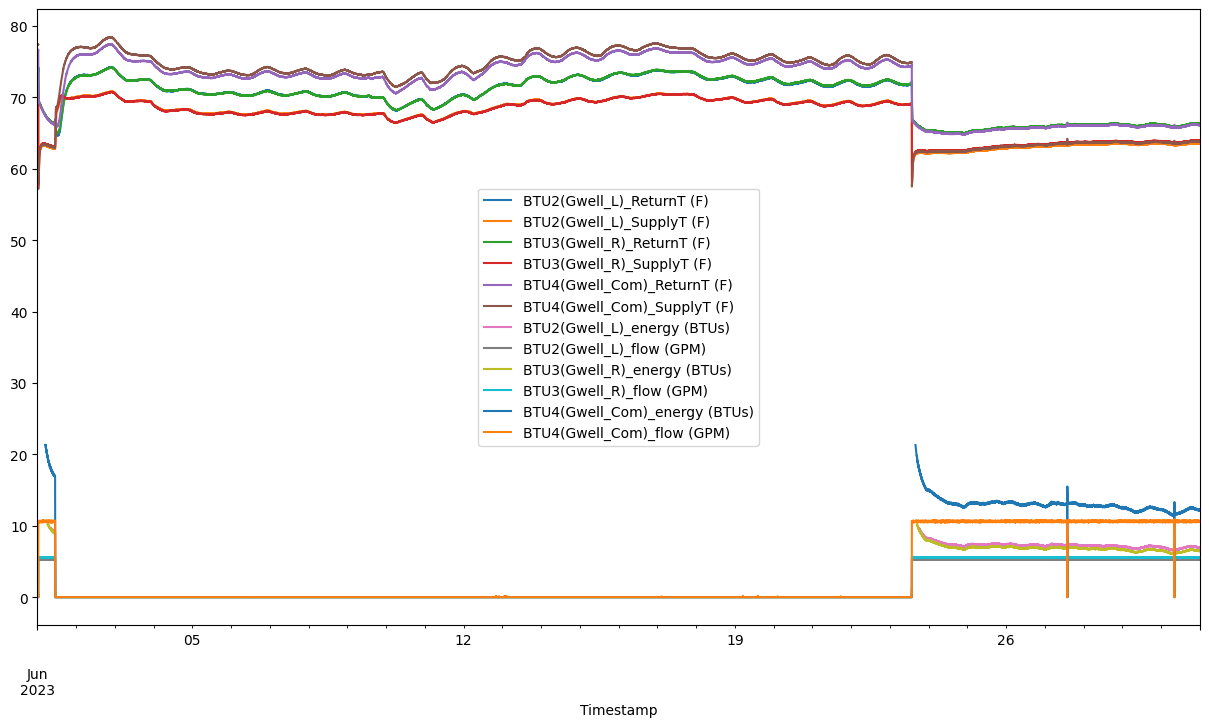

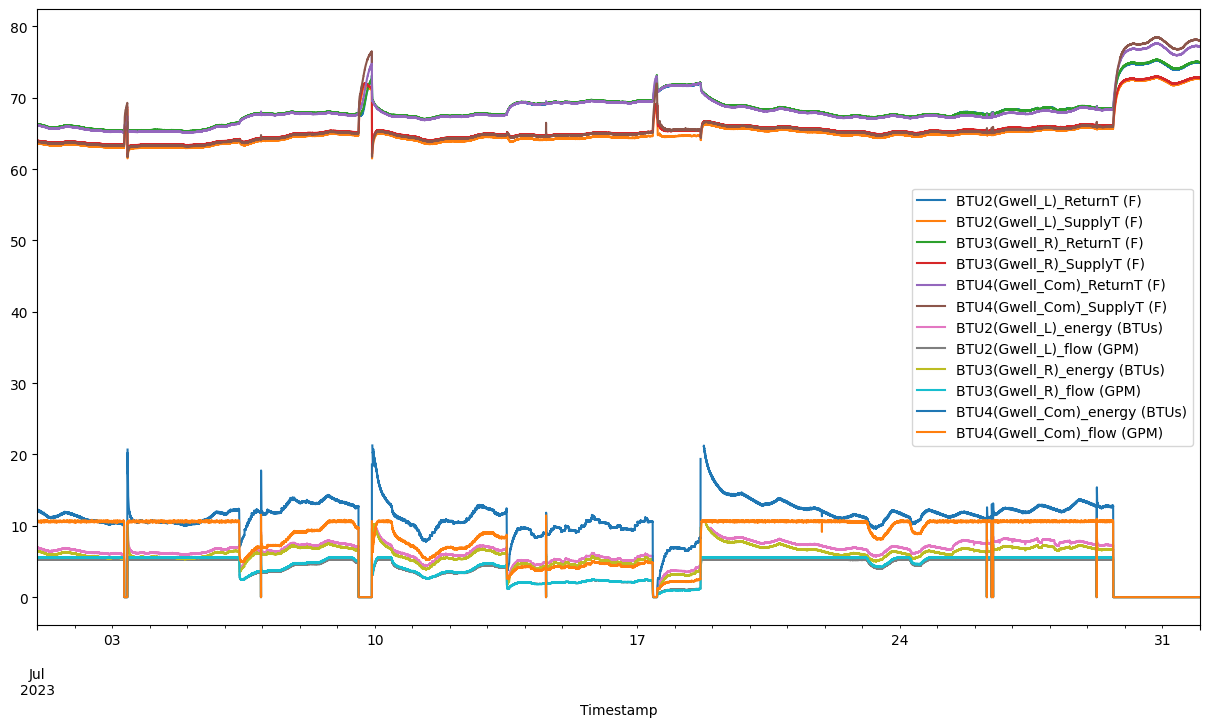

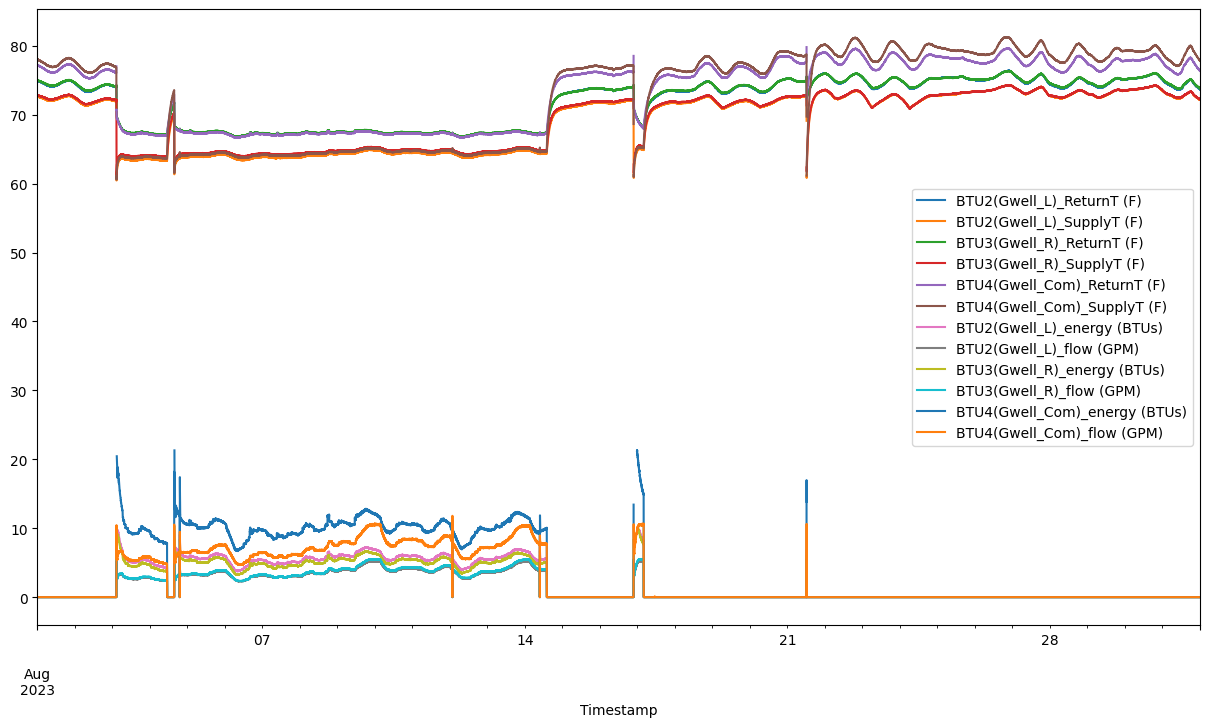

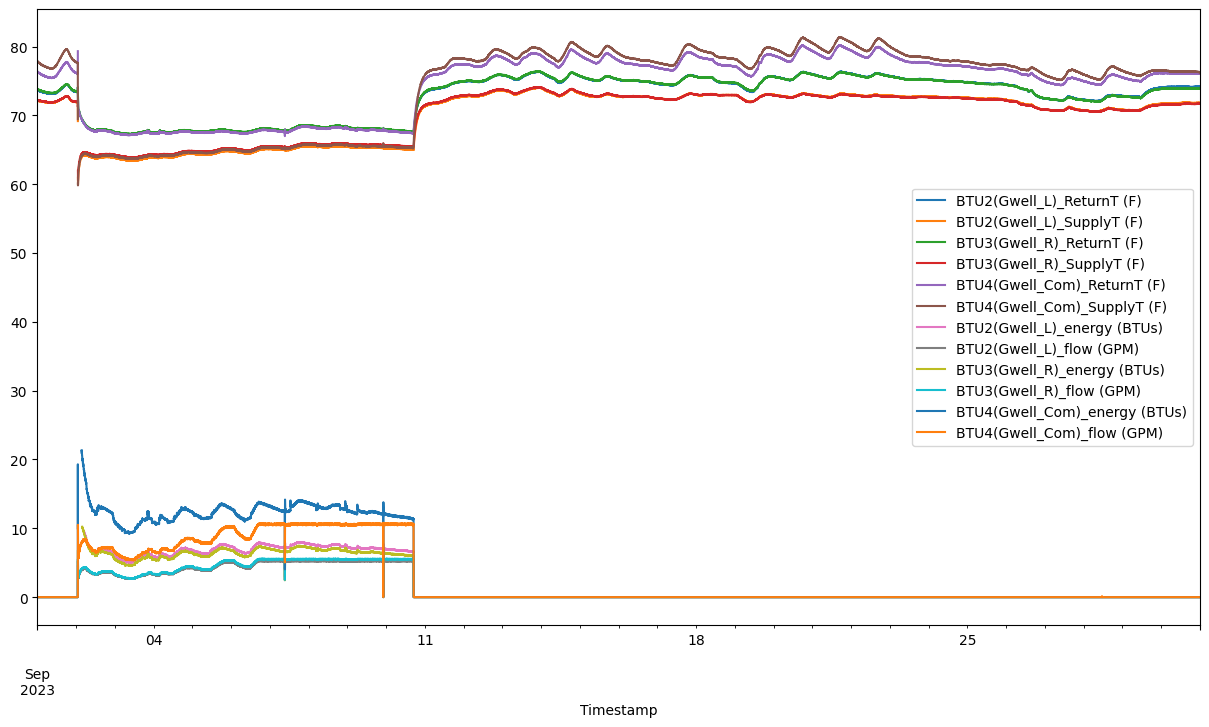

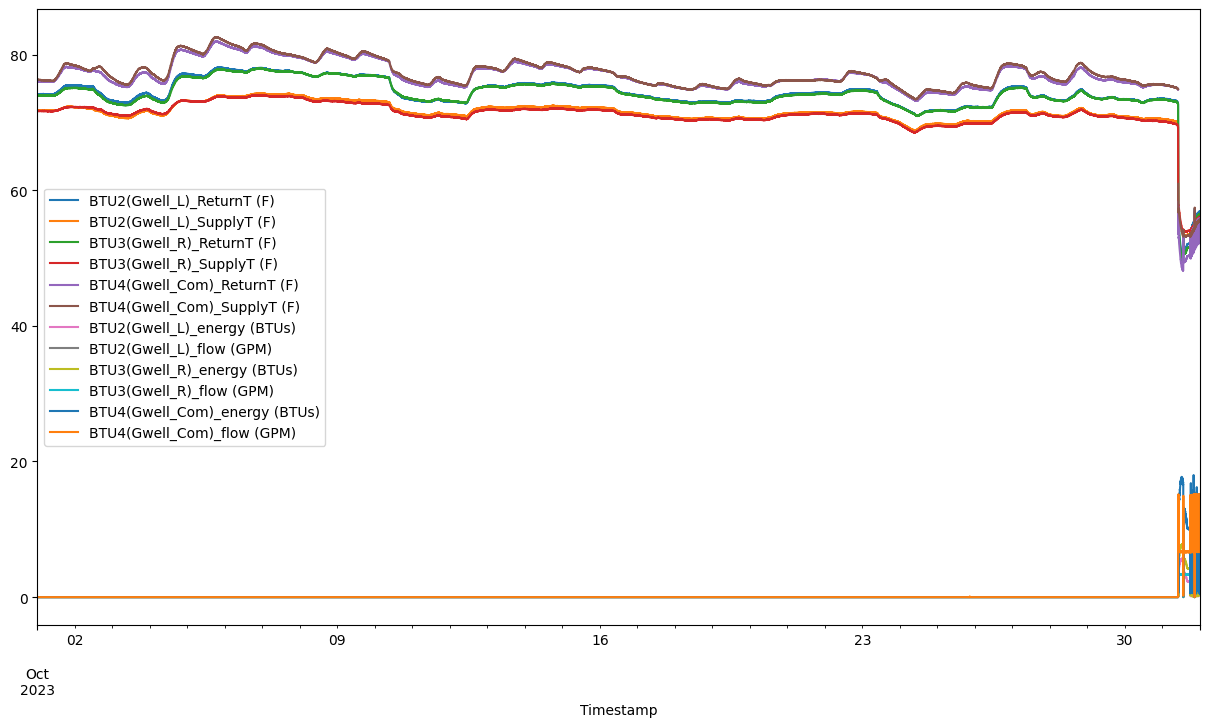

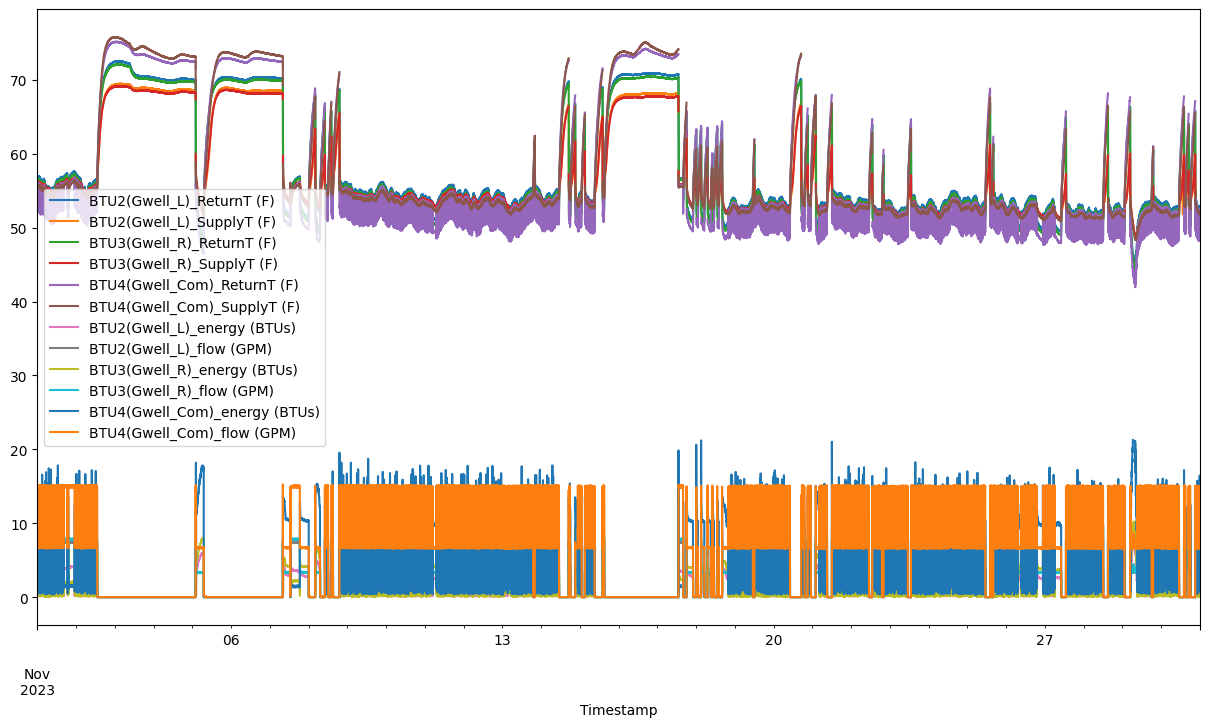

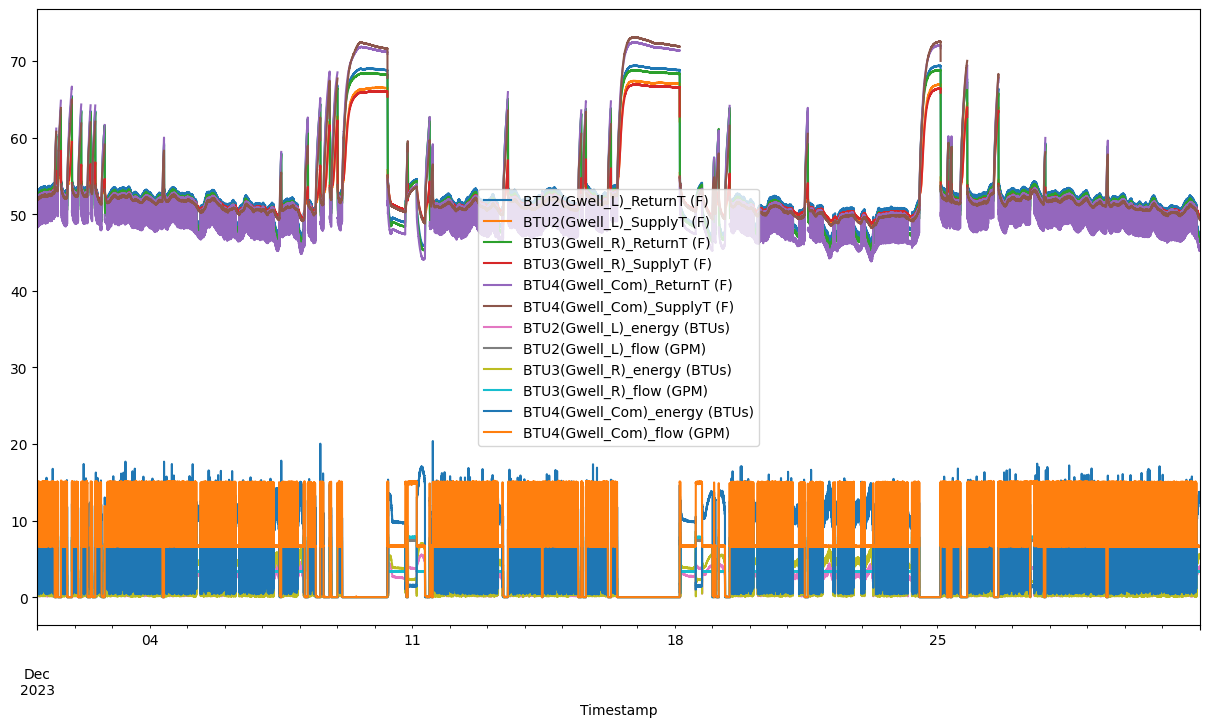

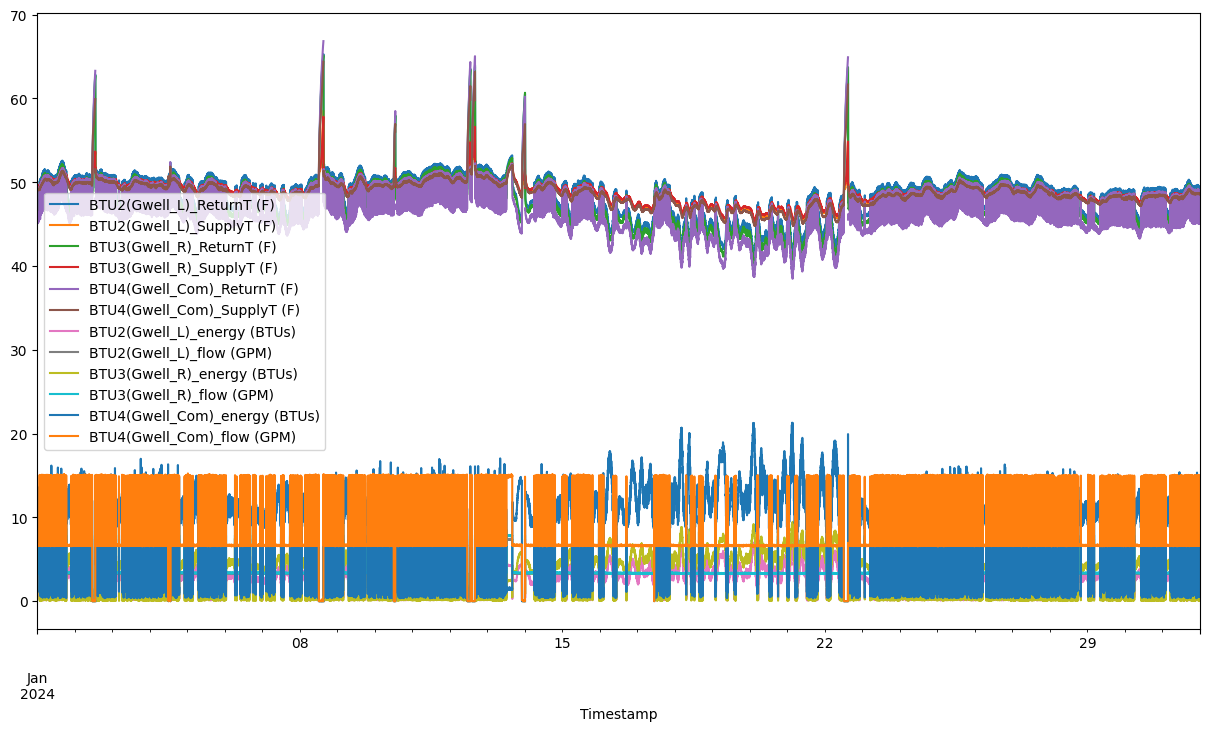

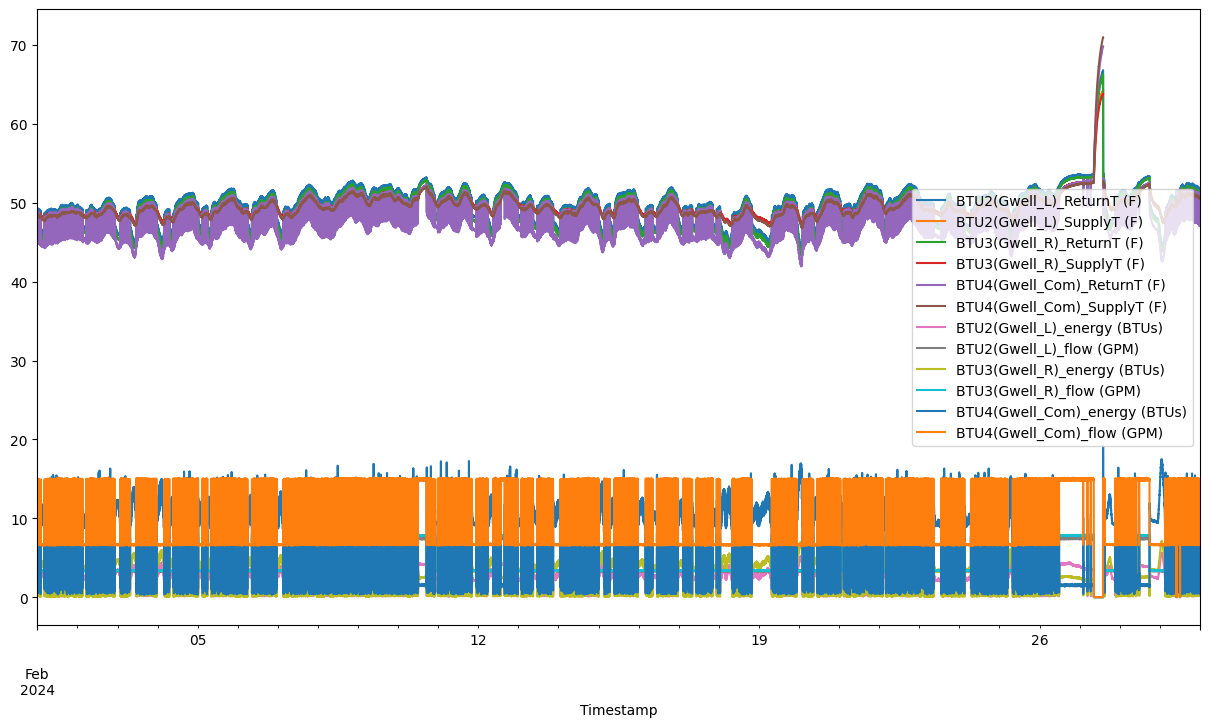

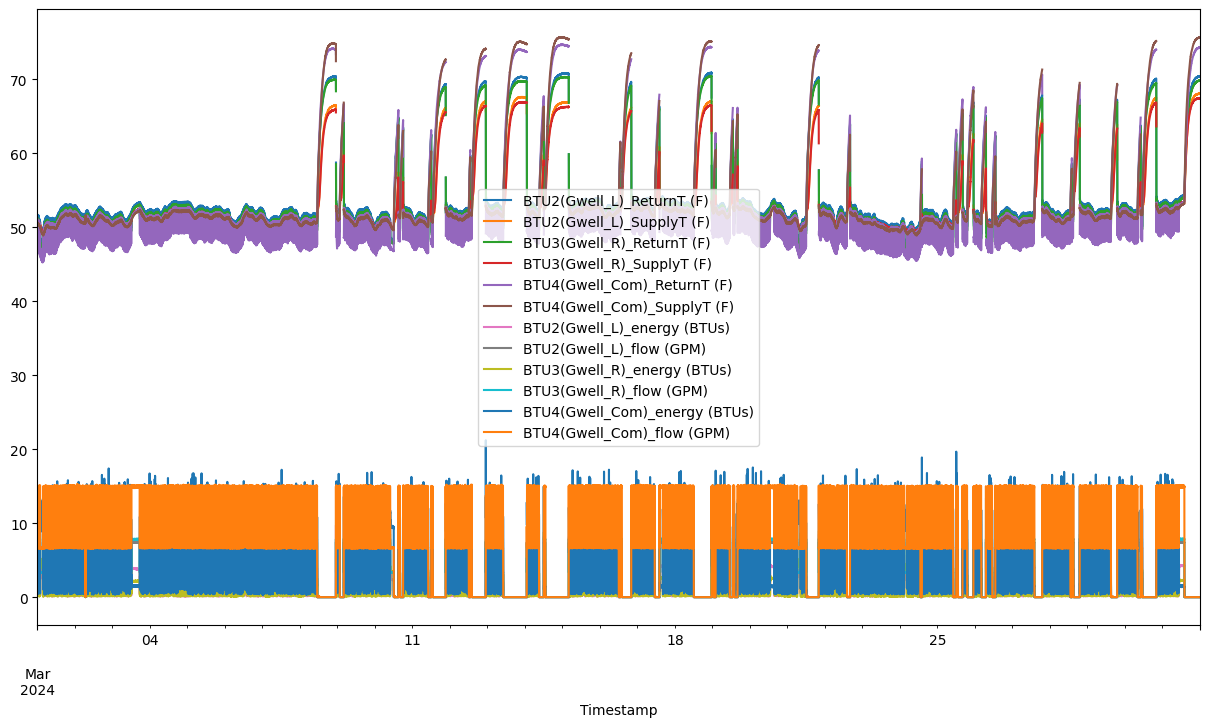

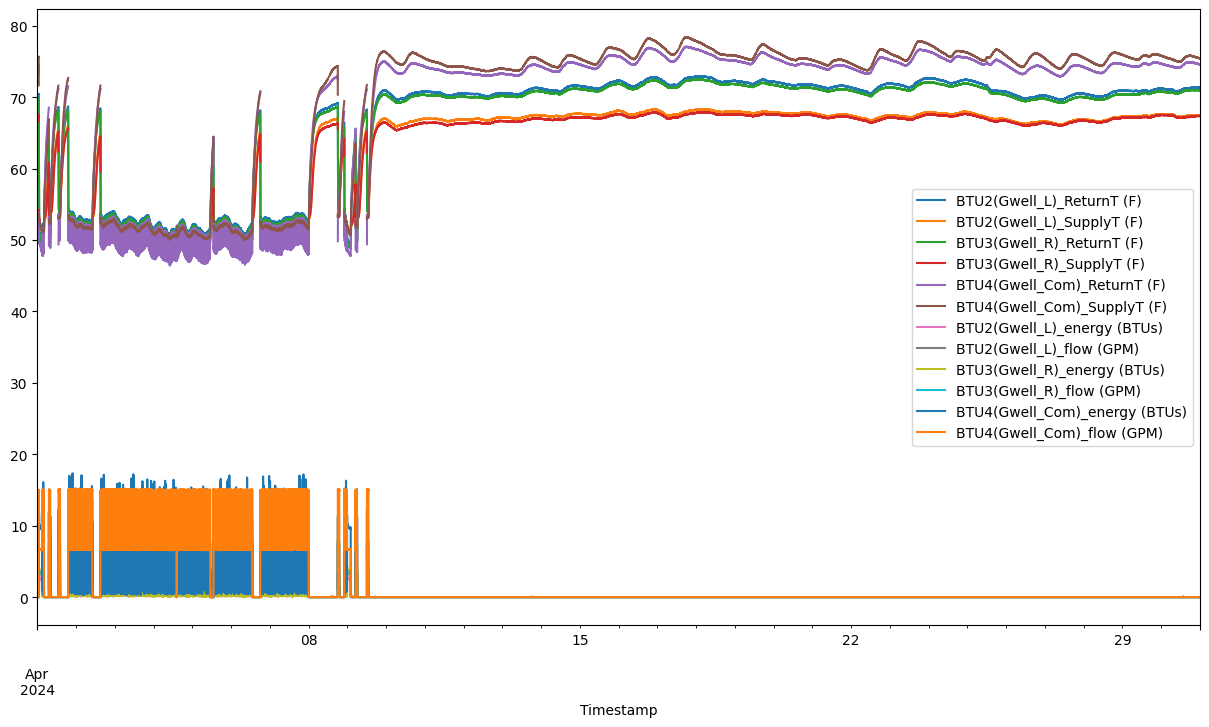

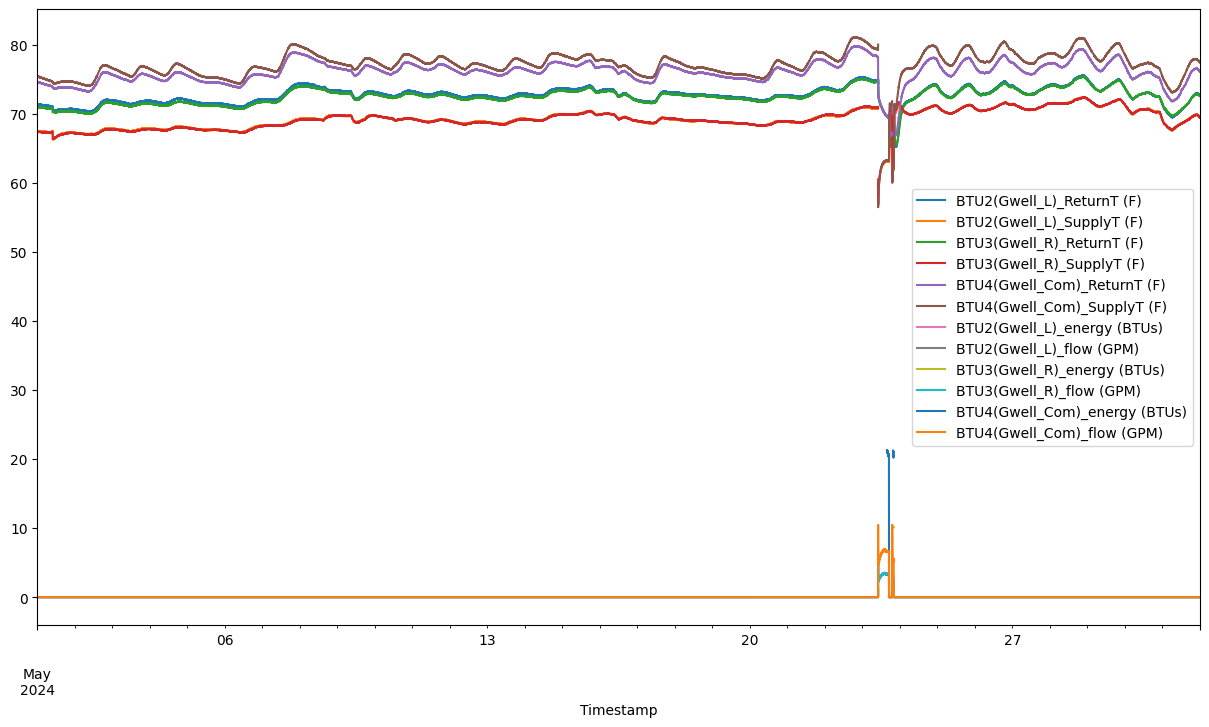

In [35]:
for (year, month), group in df_total.groupby([df_total.index.year, df_total.index.month]):

    group.plot(figsize=(15, 8))

C:\Users\Sang\AppData\Local\Temp\ipykernel_34204\3466276560.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_total = df_total.resample("H").mean().ffill()


<Axes: xlabel='Timestamp'>

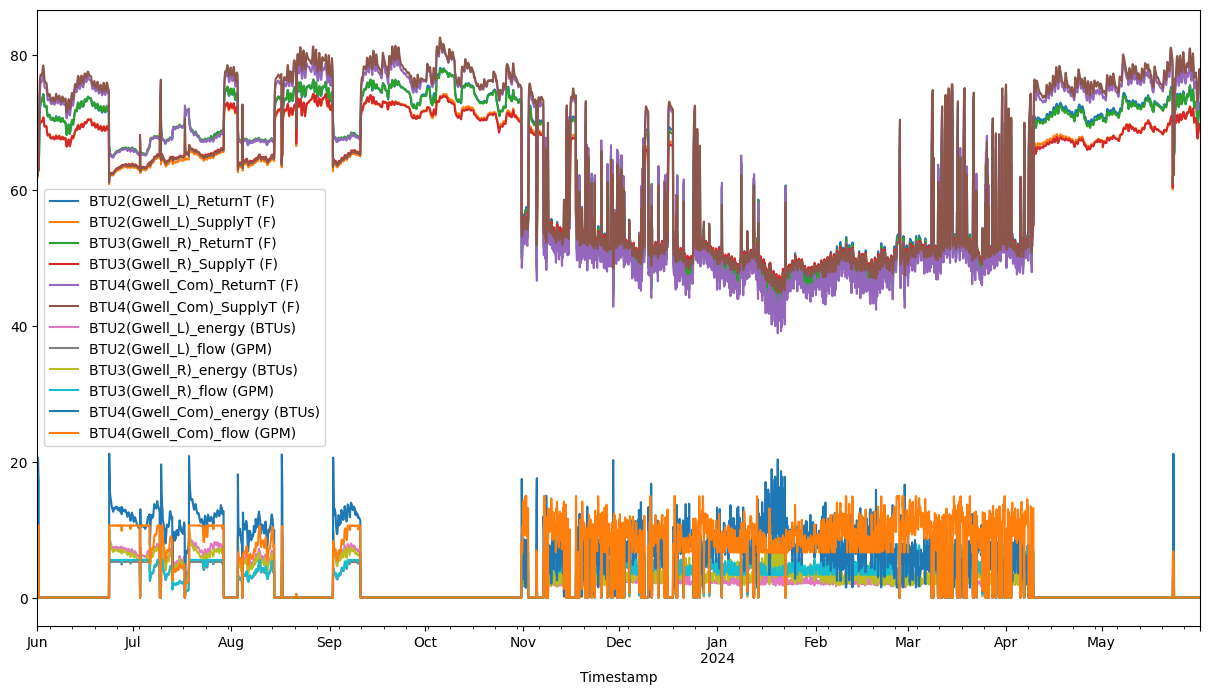

In [36]:
#Process to Hourly and forward fill (average to hour and forward fill to assign last existing value to a missing value)
df_total = df_total.resample("H").mean().ffill()

df_total.plot(figsize=(15, 8))

In [37]:
#Missing data check code
def find_nan_sequences(series):
    is_nan = series.isna()
    if is_nan.any():
        start = end = None
        for i, val in enumerate(is_nan):
            if val and start is None:
                start = i
            elif not val and start is not None:
                end = i - 1
                yield (series.index[start], series.index[end])
                start = end = None
        if start is not None:
            yield (series.index[start], series.index[-1])

# Find and print start and end indices of NaN sequences in each column
empDF = pd.DataFrame()
LstN = []
LstS = []
LstE = []

for column in df_total.columns:
    for start, end in find_nan_sequences(df_total[column]):
        print(f"Missing period:'{column}' from {start} to {end}")
        LstN.append(column)
        LstS.append(start)
        LstE.append(end)
        
empDF["names"] = LstN
empDF["start"] = LstS
empDF["end"] = LstE

In [38]:
empDF.to_csv(r'C:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Final_Processing_Code_2024\Missing Intervals\Year4\Missing_periods_BTU_GEO_Year4.csv', index=False)

In [40]:
#To csv for processed data
df_total.to_csv(r'C:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Final_Processing_Code_2024\Processed\Desigo\Year4\Zone_BTU_GEO_Year4.csv', index=True)